# Import Library: 분석에 사용할 모듈 설치
**1. Import Library**

In [1]:
!python -m pip install --user --upgrade pip

In [2]:
# Ignore the warnings
import warnings
# warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# System related and data input controls
import os

# Data manipulation and visualization
from sklearn.datasets import fetch_california_housing
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_rows = 20
pd.options.display.max_columns = 20
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn import preprocessing

# Modeling algorithms
# General
import statsmodels.api as sm
from scipy import stats
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
tf.get_logger().warning('test')
import tensorflow_addons as tfa
from tensorflow.keras import layers, regularizers, callbacks
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Input, Dense, Activation, Flatten, Dropout, Reshape
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU
from tensorflow.keras.utils import plot_model

# Model selection
from sklearn.model_selection import train_test_split, TimeSeriesSplit

# Evaluation metrics
from sklearn import metrics

In [3]:
def reshape_1Dto2Dseq(df, seq_length):
    # 2D X & Y split
    X_reshape, Y_reshape = [], []
    for index in range(len(df) - seq_length): # 2D: seq_length+1
        X_reshape.append(np.array(df[index: index + seq_length]))
        Y_reshape.append(np.ravel(df[index + seq_length:index + seq_length + 1])) # 2D(first): seq_length-1
    X_reshape, Y_reshape = np.array(X_reshape), np.array(Y_reshape)    
    
    # reshape
    X_reshape = pd.DataFrame(X_reshape.reshape(X_reshape.shape[0], -1), index=df.index[seq_length:])
    Y_reshape = pd.DataFrame(Y_reshape, columns=df.columns, index=df.index[seq_length:])
    
    return X_reshape, Y_reshape


def datasplit_cross_traintest(df, Y_colname, test_ratio, 
                              random_seed=123, shape_show=True):
    # setting
    X_colname = [i for i in df.columns if i not in Y_colname]
    
    # train / test / X / Y split
    X_train, X_test, Y_train, Y_test = train_test_split(df[X_colname], 
                                                        df[Y_colname], 
                                                        test_size=test_ratio,
                                                        random_state=random_seed)
    
    # result
    if shape_show:
        print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
        print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)
    
    return X_train, X_test, Y_train, Y_test


def datasplit_timeseries_ratio(df, Y_colname, test_ratio=0.4, 
                               shape_show=True):
    # setting
    test_size = int(df.shape[0] * test_ratio)
    
    # train / test split
    df_train = df.iloc[:-test_size,:]
    df_test = df.iloc[-test_size:,:]
    
    # X / Y split
    X_colname = [i for i in df.columns if i not in Y_colname]
    Y_train = df_train[Y_colname]
    X_train = df_train[X_colname]
    Y_test = df_test[Y_colname]
    X_test = df_test[X_colname]
    
    # result
    if shape_show:
        print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
        print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)
    
    return X_train, X_test, Y_train, Y_test


def reshape_2Dto3Dseq(df_X, df_Y, seq_length):
    # generate sequence
    X_reshape, Y_reshape = [], []
    for index in range(len(df_X) - seq_length + 1):
        X_reshape.append(np.array(df_X[index: index + seq_length]))
        Y_reshape.append(np.ravel(df_Y[index + seq_length - 1:index + seq_length]))
    X_reshape, Y_reshape = np.array(X_reshape), np.array(Y_reshape)
    
    # reshape
    X_reshape = X_reshape.reshape(X_reshape.shape[0], seq_length, -1)
    Y_reshape = pd.DataFrame(Y_reshape, index=df_Y.index[seq_length-1:], columns=df_Y.columns)
    
    return X_reshape, Y_reshape


# Learning Plot
def evaluation_reg_LearningPlot(fit_class, figsize=(10,3), 
                            label_first='Training', label_second='Validation'):
    for i in range(int(len(fit_class.history.keys())/2)):
        if i == 0:
            # Loss Plot
            plt.figure(figsize=figsize)
            plt.plot(fit_class.history['loss'], color='b', 
                     label=label_first+' Loss')
            plt.plot(fit_class.history['val_loss'], color='r', 
                     label=label_second+' Loss')
        elif i == 1:
            # MAE Plot
            plt.figure(figsize=figsize)
            plt.plot(fit_class.history['mae'], color='b', 
                     label=label_first+' MAE')
            plt.plot(fit_class.history['val_mae'], color='r', 
                     label=label_second+' MAE')
        elif i == 2:
            # MSE Plot
            plt.figure(figsize=figsize)
            plt.plot(fit_class.history['mse'], color='b', 
                     label=label_first+' MSE')
            plt.plot(fit_class.history['val_mse'], color='r', 
                     label=label_second+' MSE')
        else:
            # MAPE Plot
            plt.figure(figsize=figsize)
            plt.plot(fit_class.history['mape'], color='b', 
                     label=label_first+' MAPE')
            plt.plot(fit_class.history['val_mape'], color='r', 
                     label=label_second+' MAPE')
        plt.xlabel('Epoch', fontsize=15)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.legend(loc='best', shadow=True, fontsize=12)
        plt.show()
        
        
def evaluation_reg_MAE_MSE_MAPE(Y_real, Y_pred):
    # length check
    loss_length = len(Y_real.values.flatten()) - len(Y_pred)
    if loss_length != 0:
        Y_real = Y_real[loss_length:]
    
    # evaluator
    MAE = metrics.mean_absolute_error(Y_real, Y_pred)
    MSE = metrics.mean_squared_error(Y_real, Y_pred)
    MAPE = metrics.mean_absolute_percentage_error(Y_real, Y_pred)
    
    # rearrange
    Score = pd.DataFrame([MAE, MSE, MAPE], index=['MAE', 'MSE', 'MAPE'], columns=['Score']).T
    Residual = Y_real - Y_pred
    
    return Score, Residual
        
        
def evaluation_reg_PredPlot(Y_real, Y_pred, title='Algorithm',
                        xlabel='Sequence', ylabel='Price'):
    df_Y = pd.concat([Y_real, pd.DataFrame(Y_pred, 
                                           index=Y_real.index)], axis=1)
    df_Y.columns = ['Real Value', 'Predicted Value']
    df_Y.plot(kind='line', figsize=(18,6), linewidth=3, fontsize=20,
              xlim=(Y_real.index.min(),Y_real.index.max()))
    plt.title(title, fontsize=20)
    plt.xlabel(xlabel, fontsize=20)
    plt.ylabel(ylabel, fontsize=20)
    plt.legend(fontsize=16)
    plt.grid()
    plt.show()
    
    
def stationarity_adf_test(Y_Data, Target_name):
    if len(Target_name) == 0:
        Stationarity_adf = pd.Series(sm.tsa.stattools.adfuller(Y_Data)[0:4],
                                     index=['Test Statistics', 'p-value', 'Used Lag', 'Used Observations'])
        for key, value in sm.tsa.stattools.adfuller(Y_Data)[4].items():
            Stationarity_adf['Critical Value(%s)'%key] = value
            Stationarity_adf['Maximum Information Criteria'] = sm.tsa.stattools.adfuller(Y_Data)[5]
            Stationarity_adf = pd.DataFrame(Stationarity_adf, columns=['Stationarity_adf'])
    else:
        Stationarity_adf = pd.Series(sm.tsa.stattools.adfuller(Y_Data[Target_name])[0:4],
                                     index=['Test Statistics', 'p-value', 'Used Lag', 'Used Observations'])
        for key, value in sm.tsa.stattools.adfuller(Y_Data[Target_name])[4].items():
            Stationarity_adf['Critical Value(%s)'%key] = value
            Stationarity_adf['Maximum Information Criteria'] = sm.tsa.stattools.adfuller(Y_Data[Target_name])[5]
            Stationarity_adf = pd.DataFrame(Stationarity_adf, columns=['Stationarity_adf'])
    return Stationarity_adf


def stationarity_kpss_test(Y_Data, Target_name):
    if len(Target_name) == 0:
        Stationarity_kpss = pd.Series(sm.tsa.stattools.kpss(Y_Data)[0:3],
                                      index=['Test Statistics', 'p-value', 'Used Lag'])
        for key, value in sm.tsa.stattools.kpss(Y_Data)[3].items():
            Stationarity_kpss['Critical Value(%s)'%key] = value
            Stationarity_kpss = pd.DataFrame(Stationarity_kpss, columns=['Stationarity_kpss'])
    else:
        Stationarity_kpss = pd.Series(sm.tsa.stattools.kpss(Y_Data[Target_name])[0:3],
                                      index=['Test Statistics', 'p-value', 'Used Lag'])
        for key, value in sm.tsa.stattools.kpss(Y_Data[Target_name])[3].items():
            Stationarity_kpss['Critical Value(%s)'%key] = value
            Stationarity_kpss = pd.DataFrame(Stationarity_kpss, columns=['Stationarity_kpss'])
    return Stationarity_kpss


def error_analysis(Y_Data, X_Data, graph_on=False):
    X_Data = X_Data.loc[Y_Data.index]

    if graph_on == True:
        ##### Error Analysis(Plot)
        Y_Data['RowNum'] = Y_Data.reset_index().index

        # Stationarity(Trend) Analysis
        sns.set(palette="muted", color_codes=True, font_scale=2)
        sns.lmplot(x='RowNum', y=Y_Data.columns[0], data=Y_Data, line_kws={'color': 'red'},
                   fit_reg='True', size=5.2, aspect=2, ci=99, sharey=True)
        del Y_Data['RowNum']

        # Normal Distribution Analysis
        figure, axes = plt.subplots(figsize=(12,8))
        sns.distplot(Y_Data[Y_Data.columns[0]], norm_hist='True', fit=stats.norm, ax=axes)

        # Lag Analysis
        length = int(len(Y_Data[Y_Data.columns[0]])/10)
        figure, axes = plt.subplots(1, 4, figsize=(12,3))
        pd.plotting.lag_plot(Y_Data[Y_Data.columns[0]], lag=1, ax=axes[0])
        pd.plotting.lag_plot(Y_Data[Y_Data.columns[0]], lag=5, ax=axes[1])
        pd.plotting.lag_plot(Y_Data[Y_Data.columns[0]], lag=10, ax=axes[2])
        pd.plotting.lag_plot(Y_Data[Y_Data.columns[0]], lag=50, ax=axes[3])

        # Autocorrelation Analysis
        figure, axes = plt.subplots(2,1,figsize=(12,5))
        sm.tsa.graphics.plot_acf(Y_Data[Y_Data.columns[0]], lags=100, use_vlines=True, ax=axes[0])
        sm.tsa.graphics.plot_pacf(Y_Data[Y_Data.columns[0]], lags=100, use_vlines=True, ax=axes[1])

    ##### Error Analysis(Statistics)
    # Checking Stationarity
    # Null Hypothesis: The Time-series is non-stationalry
    Stationarity_adf = stationarity_adf_test(Y_Data, Y_Data.columns[0])
    Stationarity_kpss = stationarity_kpss_test(Y_Data, Y_Data.columns[0])

    # Checking of Normality
    # Null Hypothesis: The residuals are normally distributed
    Normality = pd.DataFrame([stats.shapiro(Y_Data[Y_Data.columns[0]])],
                             index=['Normality'], columns=['Test Statistics', 'p-value']).T

    # Checking for Autocorrelation
    # Null Hypothesis: Autocorrelation is absent
    Autocorrelation = pd.concat([pd.DataFrame(sm.stats.diagnostic.acorr_ljungbox(Y_Data[Y_Data.columns[0]], lags=[1,5,10,50])[0], columns=['Test Statistics']),
                                 pd.DataFrame(sm.stats.diagnostic.acorr_ljungbox(Y_Data[Y_Data.columns[0]], lags=[1,5,10,50])[1], columns=['p-value'])], axis=1).T
    Autocorrelation.columns = ['Autocorr(lag1)', 'Autocorr(lag5)', 'Autocorr(lag10)', 'Autocorr(lag50)']

    # Checking Heteroscedasticity
    # Null Hypothesis: Error terms are homoscedastic
    Heteroscedasticity = pd.DataFrame([sm.stats.diagnostic.het_goldfeldquandt(Y_Data[Y_Data.columns[0]], X_Data.values, alternative='two-sided')],
                                      index=['Heteroscedasticity'], columns=['Test Statistics', 'p-value', 'Alternative']).T
    Score = pd.concat([Stationarity_adf, Stationarity_kpss, Normality, Autocorrelation, Heteroscedasticity], join='outer', axis=1)
    index_new = ['Test Statistics', 'p-value', 'Alternative', 'Used Lag', 'Used Observations',
                 'Critical Value(1%)', 'Critical Value(5%)', 'Critical Value(10%)', 'Maximum Information Criteria']
    Score.reindex(index_new)
    
    return Score

# Deep Learning: Bike Sharing Prediction

In [4]:
### Feature engineering of all
def feature_engineering(raw):
    if 'datetime' in raw.columns:
        raw['datetime'] = pd.to_datetime(raw['datetime'])
        raw['DateTime'] = pd.to_datetime(raw['datetime'])

    if raw.index.dtype == 'int64':
        raw.set_index('DateTime', inplace=True)

    raw = raw.asfreq('H', method='ffill')

    result = sm.tsa.seasonal_decompose(raw['count'], model='additive')
    Y_trend = pd.DataFrame(result.trend)
    Y_trend.fillna(method='ffill', inplace=True)
    Y_trend.fillna(method='bfill', inplace=True)
    Y_trend.columns = ['count_trend']
    Y_seasonal = pd.DataFrame(result.seasonal)
    Y_seasonal.fillna(method='ffill', inplace=True)
    Y_seasonal.fillna(method='bfill', inplace=True)
    Y_seasonal.columns = ['count_seasonal']
    pd.concat([raw, Y_trend, Y_seasonal], axis=1).isnull().sum()
    if 'count_trend' not in raw.columns:
        if 'count_seasonal' not in raw.columns:
            raw = pd.concat([raw, Y_trend, Y_seasonal], axis=1)

    Y_count_Day = raw[['count']].rolling(24).mean()
    Y_count_Day.fillna(method='ffill', inplace=True)
    Y_count_Day.fillna(method='bfill', inplace=True)
    Y_count_Day.columns = ['count_Day']
    Y_count_Week = raw[['count']].rolling(24*7).mean()
    Y_count_Week.fillna(method='ffill', inplace=True)
    Y_count_Week.fillna(method='bfill', inplace=True)
    Y_count_Week.columns = ['count_Week']
    if 'count_Day' not in raw.columns:
        raw = pd.concat([raw, Y_count_Day], axis=1)
    if 'count_Week' not in raw.columns:
        raw = pd.concat([raw, Y_count_Week], axis=1)

    Y_diff = raw[['count']].diff()
    Y_diff.fillna(method='ffill', inplace=True)
    Y_diff.fillna(method='bfill', inplace=True)
    Y_diff.columns = ['count_diff']
    if 'count_diff' not in raw.columns:
        raw = pd.concat([raw, Y_diff], axis=1)

    raw['temp_group'] = pd.cut(raw['temp'], 10)
    raw['Year'] = raw.datetime.dt.year
    raw['Quater'] = raw.datetime.dt.quarter
    raw['Quater_ver2'] = raw['Quater'] + (raw.Year - raw.Year.min()) * 4
    raw['Month'] = raw.datetime.dt.month
    raw['Day'] = raw.datetime.dt.day
    raw['Hour'] = raw.datetime.dt.hour
    raw['DayofWeek'] = raw.datetime.dt.dayofweek

    raw['count_lag1'] = raw['count'].shift(1)
    raw['count_lag2'] = raw['count'].shift(2)
    raw['count_lag1'].fillna(method='bfill', inplace=True)
    raw['count_lag2'].fillna(method='bfill', inplace=True)

    if 'Quater' in raw.columns:
        if 'Quater_Dummy' not in ['_'.join(col.split('_')[:2]) for col in raw.columns]:
            raw = pd.concat([raw, pd.get_dummies(raw['Quater'], 
                                                 prefix='Quater_Dummy', drop_first=True)], axis=1)
            del raw['Quater']
    raw_fe = raw.copy()
    return raw_fe


### duplicate previous year values to next one
def feature_engineering_year_duplicated(raw, target):
    raw_fe = raw.copy()
    for col in target:
        raw_fe.loc['2012-01-01':'2012-02-28', col] = raw.loc['2011-01-01':'2011-02-28', col].values
        raw_fe.loc['2012-03-01':'2012-12-31', col] = raw.loc['2011-03-01':'2011-12-31', col].values
        step = (raw.loc['2011-03-01 00:00:00', col] - raw.loc['2011-02-28 23:00:00', col])/25
        step_value = np.arange(raw.loc['2011-02-28 23:00:00', col]+step, raw.loc['2011-03-01 00:00:00', col], step)
        step_value = step_value[:24]
        raw_fe.loc['2012-02-29', col] = step_value
    return raw_fe


### modify lagged values of X_test
def feature_engineering_lag_modified(Y_test, X_test, target):
    X_test_lm = X_test.copy()
    for col in target:
        X_test_lm[col] = Y_test.shift(1).values
        X_test_lm[col].fillna(method='bfill', inplace=True)
        X_test_lm[col] = Y_test.shift(2).values
        X_test_lm[col].fillna(method='bfill', inplace=True)
    return X_test_lm


## Parameters Setting

In [5]:
Y_colname = ['count']
X_remove = ['datetime', 'DateTime', 'temp_group', 'casual', 'registered']
scaler = preprocessing.MinMaxScaler()
tf.random.set_seed(123)
TEST_RATIO = 0.1
SEQUENCE = 10 # not MLP
DROPOUT_RATIO = 0.2
BATCH_SIZE = 32
EPOCHS = 50 # 100
VERBOSE = 0
# Callback Direct
EARLYSTOP_PATIENT = 20
CALLBACK = tfa.callbacks.TQDMProgressBar(show_epoch_progress=False)
#################
RESULT_LOCATION = os.path.join(os.getcwd(),'Result','BikeSharing_')
RESULT_DPI = 150
ALGO_NAMES = ['MLP', 'CNN', 'RNN', 'LSTM', 'GRU']

## MLP

X_train: (4500, 24) Y_train: (4500, 1)
X_val: (250, 24) Y_val: (250, 1)
X_test: (250, 24) Y_test: (250, 1)
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 24)]              0         
_________________________________________________________________
dense (Dense)                (None, 128)               3200      
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 11,521

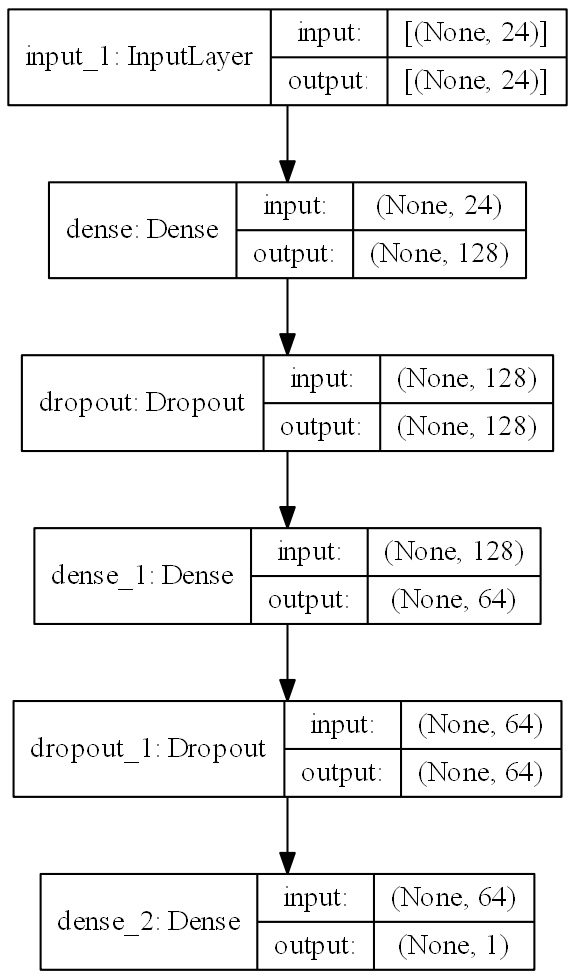

Training:   0%|                                                                                      0/50 ETA:…

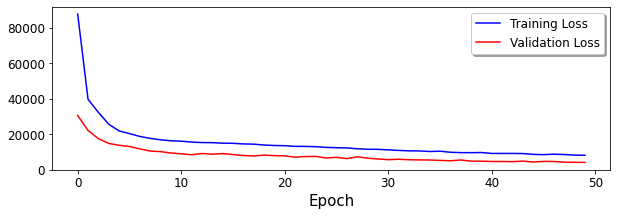

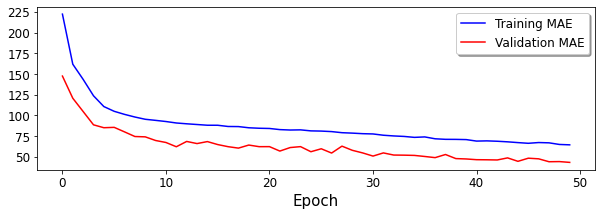

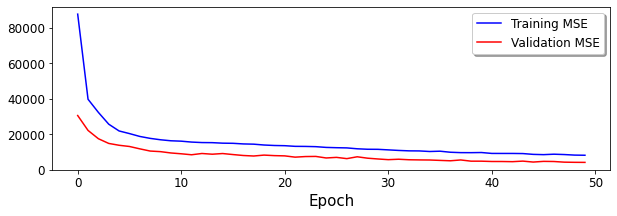

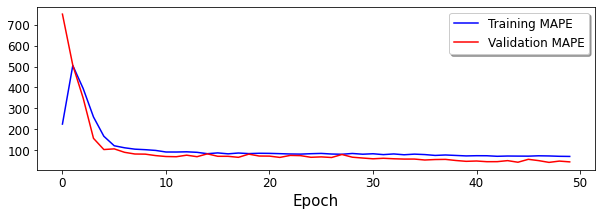

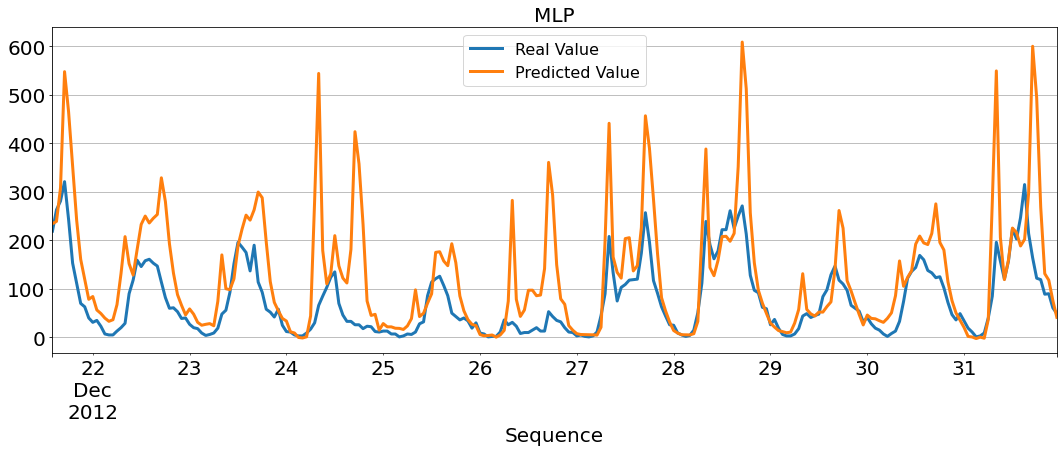

MAE       MSE  MAPE
Score 62.85 10,780.04  1.70

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

Stationarity_adf  Stationarity_kpss  Normality  \
Test Statistics                          -4.73               0.28       0.79   
p-value                                   0.00               0.10       0.00   
Used Lag                                  9.00              16.00        NaN   
Used Observations                       240.00                NaN        NaN   
Critical Value(1%)                       -3.46                NaN        NaN   
Maximum Information Criteria          2,589.05                NaN        NaN   
Critical Value(10%)                        NaN               0.35        NaN   
Alternative                                NaN                NaN        NaN   

                              Autocorr(lag1)  Autocorr(lag5)  Autocorr(lag10)  \
Test Statistics                        95.27          106.94           142.54   
p-value                                 0.00            0.00             0.00   
Used Lag                                 NaN             NaN              NaN   
Used Observations                        NaN             NaN              NaN   
Critical Value(1%)                       NaN             NaN              NaN   
Maximum Information Criteria             NaN             NaN              NaN   
Critical Value(10%)                      NaN             NaN              NaN   
Alternative                              NaN             NaN              NaN   

                              Autocorr(lag50) Heteroscedasticity  
Test Statistics                        511.97               1.32  
p-value                                  0.00               0.15  
Used Lag                                  NaN                NaN  
Used Observations                         NaN                NaN  
Critical Value(1%)                        NaN                NaN  
Maximum Information Criteria              NaN                NaN  
Critical Value(10%)                       NaN                NaN  
Alternative                               NaN          two-sided

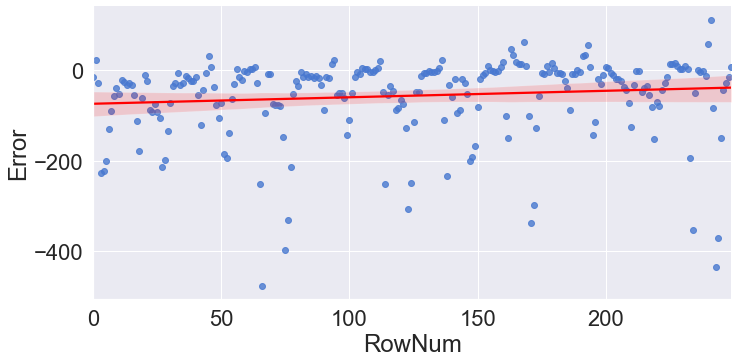

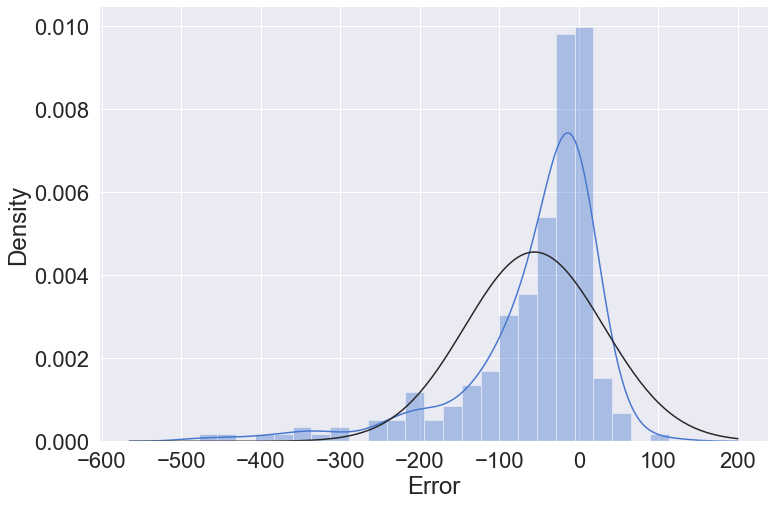

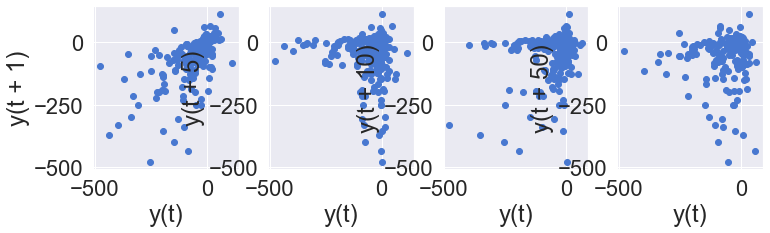

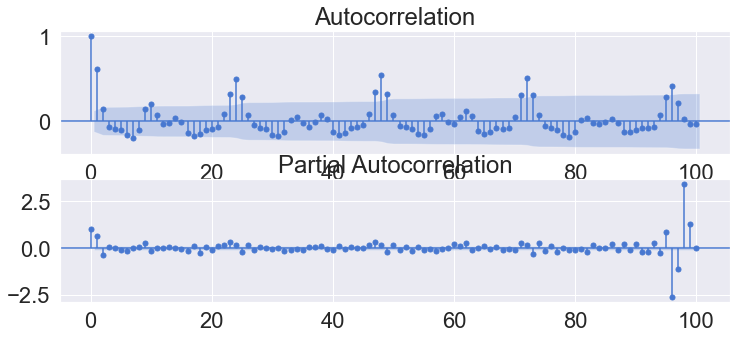

In [6]:
# Data Loading
location = os.path.join(os.getcwd(),'Data','BikeSharingDemand','Bike_Sharing_Demand_Full.csv')
df = pd.read_csv(location)

# Preprocessing
X_colname = [x for x in df.columns if x not in Y_colname+X_remove]
df = feature_engineering(df)

X_colname = [x for x in df.columns if x not in Y_colname+X_remove]
target = ['count_trend', 'count_seasonal', 'count_Day', 'count_Week', 'count_diff']
df = feature_engineering_year_duplicated(df, target)
df = df[Y_colname + X_colname].copy()
df = df[-5000:].copy()

X_train, X_test, \
Y_train, Y_test = datasplit_timeseries_ratio(df, Y_colname, 
                                             test_ratio=TEST_RATIO, shape_show=False)
X_val, X_test, \
Y_val, Y_test = datasplit_timeseries_ratio(pd.concat([X_test, Y_test], axis=1), Y_colname, 
                                           test_ratio=0.5, shape_show=False)
target = ['count_lag1', 'count_lag2']
X_train = feature_engineering_lag_modified(Y_train, X_train, target)
X_val = feature_engineering_lag_modified(Y_val, X_val, target)
X_test = feature_engineering_lag_modified(Y_test, X_test, target)

# Scaling
scaler_fit = scaler.fit(X_train)
X_train = scaler_fit.transform(X_train)
X_val = scaler_fit.transform(X_val)
X_test = scaler_fit.transform(X_test)
print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
print('X_val:', X_val.shape, 'Y_val:', Y_val.shape)
print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

# MLP
inputs = Input(shape=(X_train.shape[1],))
hiddens = Dense(128, activation='relu')(inputs)
hiddens = Dropout(DROPOUT_RATIO)(hiddens)
# hiddens = Dense(256, activation='relu')(hiddens)
# hiddens = Dropout(DROPOUT_RATIO)(hiddens)
# hiddens = Dense(128, activation='relu')(hiddens)
# hiddens = Dropout(DROPOUT_RATIO)(hiddens)
hiddens = Dense(64, activation='relu')(hiddens)
hiddens = Dropout(DROPOUT_RATIO)(hiddens)
outputs = Dense(1)(hiddens)
algo_MLP = Model(inputs, outputs)
algo_MLP.summary()
display(plot_model(algo_MLP, to_file=RESULT_LOCATION+'MLP.png', 
                   show_shapes=True, dpi=RESULT_DPI))

# Learning
CALLBACK = [tfa.callbacks.TQDMProgressBar(show_epoch_progress=False),
            callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                    patience=EARLYSTOP_PATIENT, verbose=1),
            callbacks.ModelCheckpoint(monitor='val_loss', mode='min', save_best_only=True, 
                                      filepath=RESULT_LOCATION+'MLP.h5')]

algo_MLP.compile(loss='mse', optimizer='adam',
                 metrics=['mae', 'mse', 'mape'])
algo_MLPfit = algo_MLP.fit(X_train, Y_train, 
                           batch_size=BATCH_SIZE, epochs=EPOCHS,
                           validation_data=(X_val, Y_val),
                           verbose=VERBOSE,
                           callbacks=[CALLBACK])
evaluation_reg_LearningPlot(algo_MLPfit)

# Prediction
Y_pred = algo_MLP.predict(X_test)
Y_pred = pd.DataFrame(Y_pred, index=Y_test.index, columns=Y_colname)

# Evaluation
evaluation_reg_PredPlot(Y_test, Y_pred, title='MLP', ylabel='')
Score, Resid_te = evaluation_reg_MAE_MSE_MAPE(Y_test, Y_pred)
display(Score)

# Error Analysis
Resid_te.rename(columns={Y_colname[0]:'Error'}, inplace=True)
X_test = pd.DataFrame(X_test, index=Y_test.index, columns=X_colname)
ErrorResult = error_analysis(Resid_te, X_test, graph_on=True)
display(ErrorResult)

# Summary
Score_MLP = Score.copy()
Y_pred_MLP = Y_pred.copy()
Error_MLP = ErrorResult.copy()

### Load Best Learning

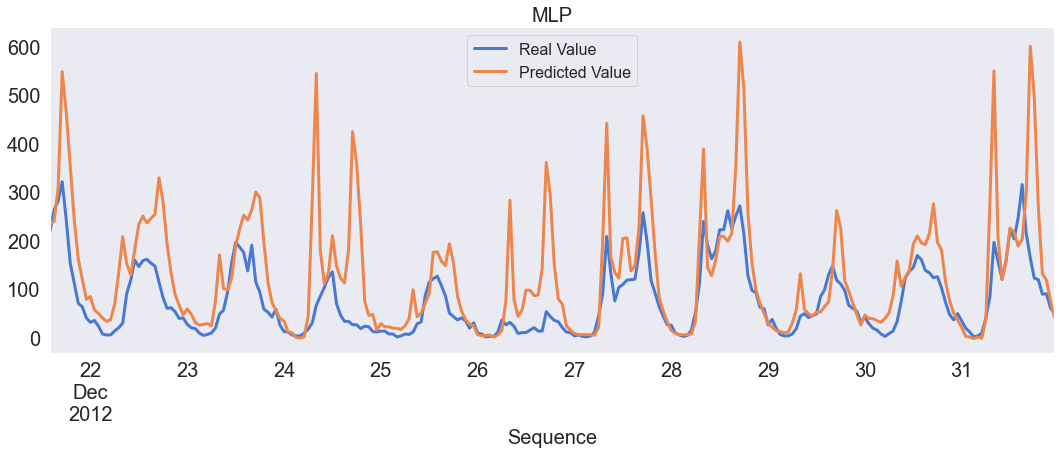

MAE       MSE  MAPE
Score 62.85 10,780.04  1.70

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

Stationarity_adf  Stationarity_kpss  Normality  \
Test Statistics                          -4.73               0.28       0.79   
p-value                                   0.00               0.10       0.00   
Used Lag                                  9.00              16.00        NaN   
Used Observations                       240.00                NaN        NaN   
Critical Value(1%)                       -3.46                NaN        NaN   
Maximum Information Criteria          2,589.05                NaN        NaN   
Critical Value(10%)                        NaN               0.35        NaN   
Alternative                                NaN                NaN        NaN   

                              Autocorr(lag1)  Autocorr(lag5)  Autocorr(lag10)  \
Test Statistics                        95.27          106.94           142.54   
p-value                                 0.00            0.00             0.00   
Used Lag                                 NaN             NaN              NaN   
Used Observations                        NaN             NaN              NaN   
Critical Value(1%)                       NaN             NaN              NaN   
Maximum Information Criteria             NaN             NaN              NaN   
Critical Value(10%)                      NaN             NaN              NaN   
Alternative                              NaN             NaN              NaN   

                              Autocorr(lag50) Heteroscedasticity  
Test Statistics                        511.97               1.32  
p-value                                  0.00               0.15  
Used Lag                                  NaN                NaN  
Used Observations                         NaN                NaN  
Critical Value(1%)                        NaN                NaN  
Maximum Information Criteria              NaN                NaN  
Critical Value(10%)                       NaN                NaN  
Alternative                               NaN          two-sided

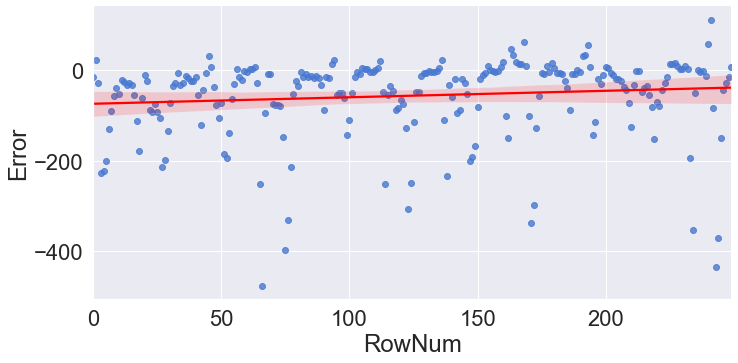

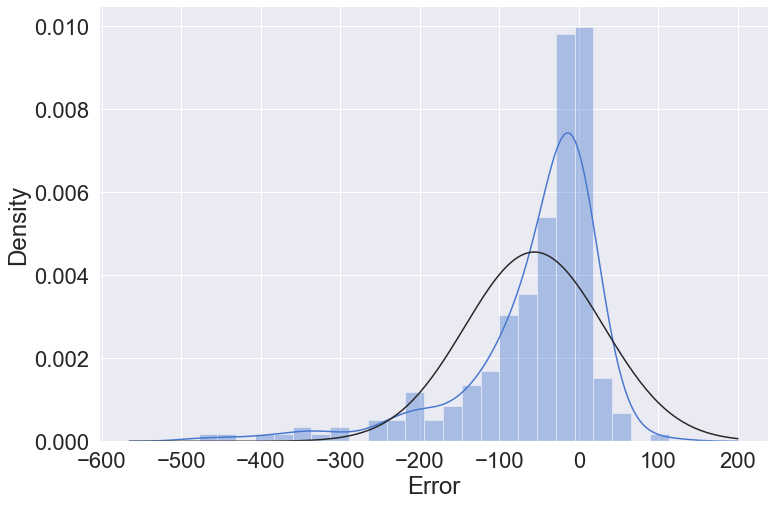

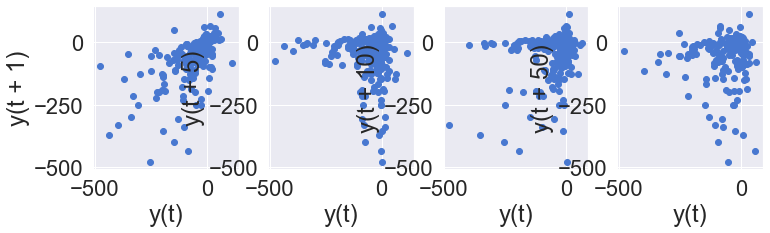

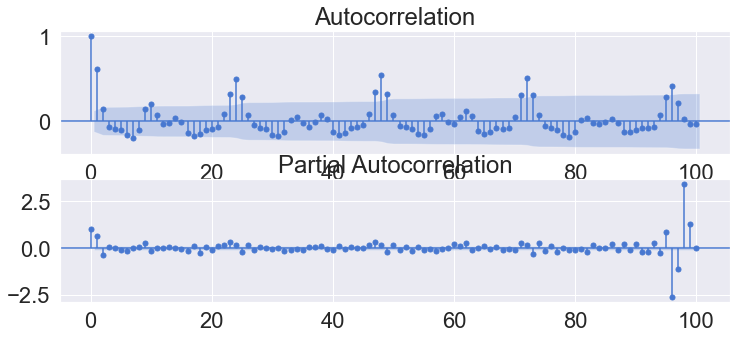

In [7]:
# Loading of Best Learning 
algo_MLP = load_model(RESULT_LOCATION+'MLP.h5')

# Prediction
Y_pred = algo_MLP.predict(X_test)
Y_pred = pd.DataFrame(Y_pred, index=Y_test.index, columns=Y_colname)

# Evaluation
evaluation_reg_PredPlot(Y_test, Y_pred, title='MLP', ylabel='')
Score, Resid_te = evaluation_reg_MAE_MSE_MAPE(Y_test, Y_pred)
display(Score)

# Error Analysis
Resid_te.rename(columns={Y_colname[0]:'Error'}, inplace=True)
X_test = pd.DataFrame(X_test, index=Y_test.index, 
                      columns=[i for i in df.columns if i not in Y_colname])
ErrorResult = error_analysis(Resid_te, X_test, graph_on=True)
display(ErrorResult)

# Summary
Score_MLP = Score.copy()
Y_pred_MLP = Y_pred.copy()
Error_MLP = ErrorResult.copy()

## CNN

X_train: (4500, 24) Y_train: (4500, 1)
X_val: (250, 24) Y_val: (250, 1)
X_test: (250, 24) Y_test: (250, 1)
X_train: (4491, 10, 24) Y_train: (4491, 1)
X_val: (250, 10, 24) Y_val: (250, 1)
X_test: (250, 10, 24) Y_test: (250, 1)
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 10, 24)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 10, 128)           30848     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 5, 128)            0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 5, 128)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 5, 64)             81984     
_______________________________

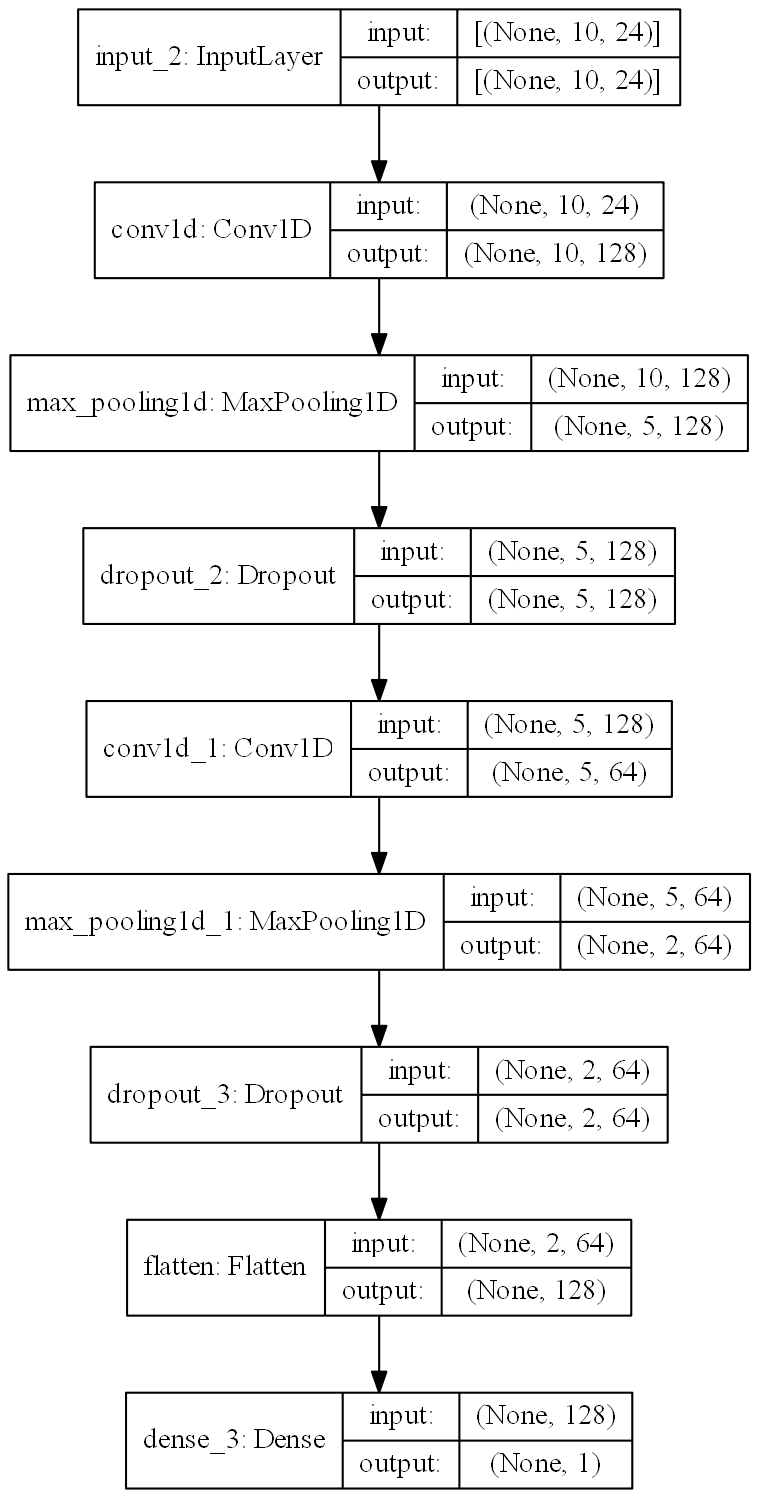

Training:   0%|                                                                                      0/50 ETA:…

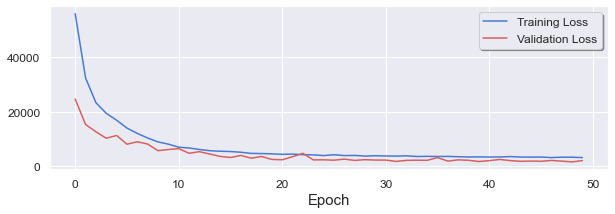

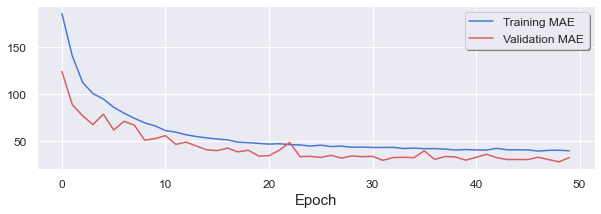

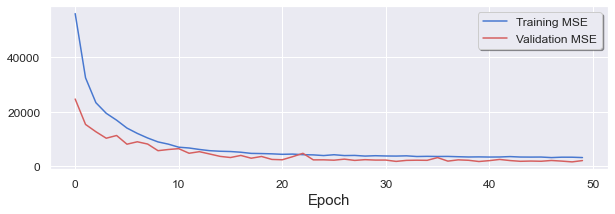

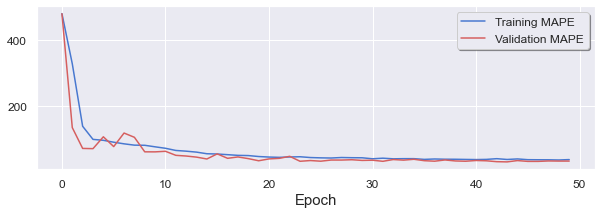

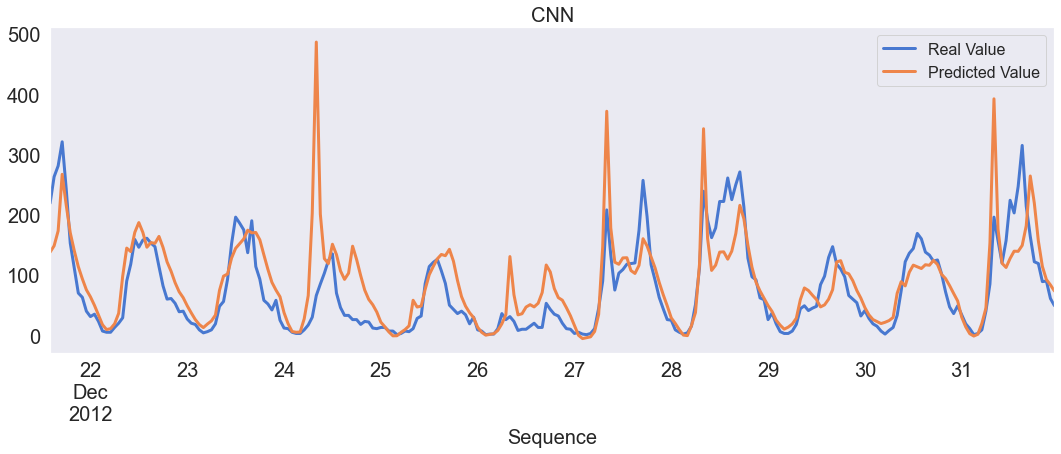

MAE      MSE  MAPE
Score 34.17 2,876.74  0.94

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

Stationarity_adf  Stationarity_kpss  Normality  \
Test Statistics                          -7.87               0.41       0.83   
p-value                                   0.00               0.07       0.00   
Used Lag                                  1.00              16.00        NaN   
Used Observations                       248.00                NaN        NaN   
Critical Value(1%)                       -3.46                NaN        NaN   
Maximum Information Criteria          2,374.56                NaN        NaN   
Critical Value(10%)                        NaN               0.35        NaN   
Alternative                                NaN                NaN        NaN   

                              Autocorr(lag1)  Autocorr(lag5)  Autocorr(lag10)  \
Test Statistics                       110.20          145.24           159.79   
p-value                                 0.00            0.00             0.00   
Used Lag                                 NaN             NaN              NaN   
Used Observations                        NaN             NaN              NaN   
Critical Value(1%)                       NaN             NaN              NaN   
Maximum Information Criteria             NaN             NaN              NaN   
Critical Value(10%)                      NaN             NaN              NaN   
Alternative                              NaN             NaN              NaN   

                              Autocorr(lag50) Heteroscedasticity  
Test Statistics                        333.23               1.22  
p-value                                  0.00               0.30  
Used Lag                                  NaN                NaN  
Used Observations                         NaN                NaN  
Critical Value(1%)                        NaN                NaN  
Maximum Information Criteria              NaN                NaN  
Critical Value(10%)                       NaN                NaN  
Alternative                               NaN          two-sided

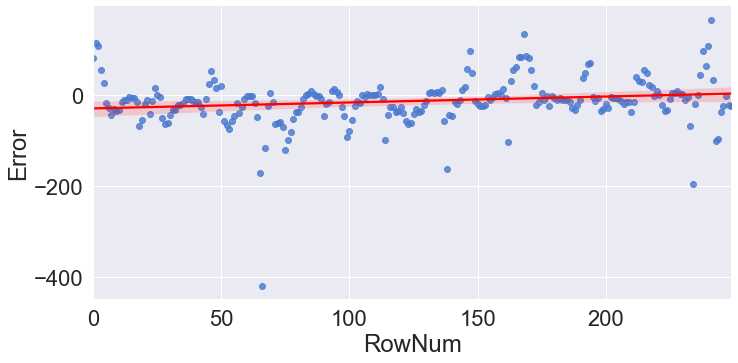

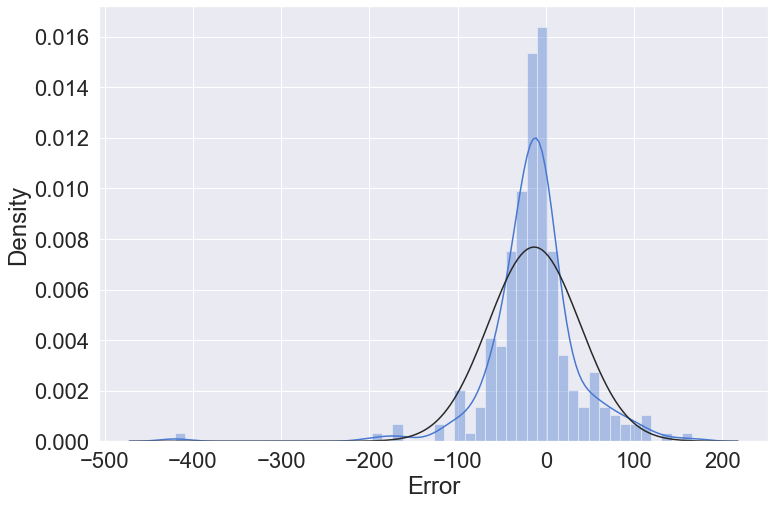

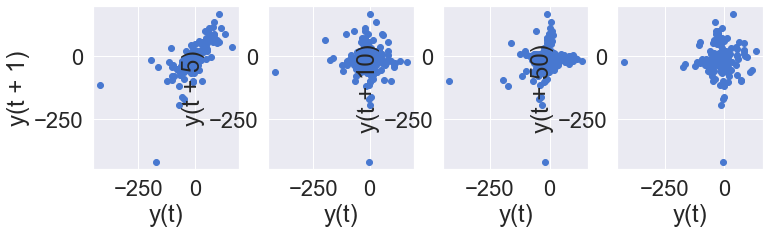

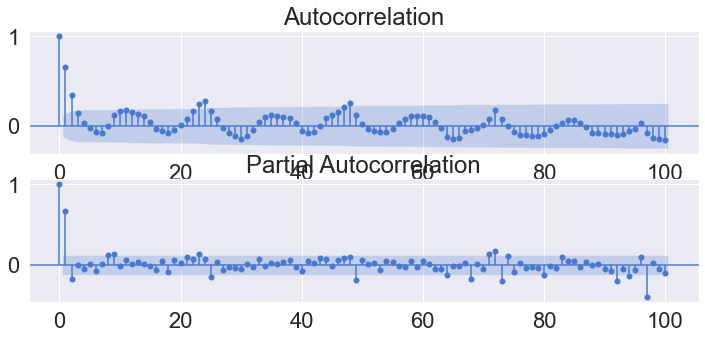

In [8]:
# Data Loading
location = os.path.join(os.getcwd(),'Data','BikeSharingDemand','Bike_Sharing_Demand_Full.csv')
df = pd.read_csv(location)

# Preprocessing
X_colname = [x for x in df.columns if x not in Y_colname+X_remove]
df = feature_engineering(df)

X_colname = [x for x in df.columns if x not in Y_colname+X_remove]
target = ['count_trend', 'count_seasonal', 'count_Day', 'count_Week', 'count_diff']
df = feature_engineering_year_duplicated(df, target)
df = df[Y_colname + X_colname].copy()
df = df[-5000:].copy()

X_train, X_test, \
Y_train, Y_test = datasplit_timeseries_ratio(df, Y_colname, 
                                             test_ratio=TEST_RATIO, shape_show=False)
X_val, X_test, \
Y_val, Y_test = datasplit_timeseries_ratio(pd.concat([X_test, Y_test], axis=1), Y_colname, 
                                           test_ratio=0.5, shape_show=False)
target = ['count_lag1', 'count_lag2']
X_train = feature_engineering_lag_modified(Y_train, X_train, target)
X_val = feature_engineering_lag_modified(Y_val, X_val, target)
X_test = feature_engineering_lag_modified(Y_test, X_test, target)

# Scaling
scaler_fit = scaler.fit(X_train)
X_train = scaler_fit.transform(X_train)
X_val = scaler_fit.transform(X_val)
X_test = scaler_fit.transform(X_test)
print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
print('X_val:', X_val.shape, 'Y_val:', Y_val.shape)
print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

# Reshape
X_test_old = X_test.copy()
X, Y = reshape_2Dto3Dseq(np.concatenate((X_train, X_val, X_test), axis=0),
                         pd.concat([Y_train, Y_val, Y_test], axis=0), SEQUENCE)
test_length = Y_test.shape[0]
X_train, Y_train = X[:-test_length*2,:,:], Y.iloc[:-test_length*2,:]
X_val, Y_val = X[-test_length*2:-test_length,:,:], Y.iloc[-test_length*2:-test_length,:]
X_test, Y_test = X[-test_length:,:,:], Y.iloc[-test_length:,:]
print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
print('X_val:', X_val.shape, 'Y_val:', Y_val.shape)
print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

# CNN
inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
hiddens = Conv1D(128, kernel_size=X_train.shape[1], padding='same', activation='relu')(inputs)
# hiddens = Conv1D(256, kernel_size=X_train.shape[1], padding='same', activation='relu')(hiddens)
hiddens = MaxPooling1D(pool_size=2)(hiddens)
hiddens = Dropout(DROPOUT_RATIO)(hiddens)
# hiddens = Conv1D(128, kernel_size=X_train.shape[1], padding='same', activation='relu')(hiddens)
hiddens = Conv1D(64, kernel_size=X_train.shape[1], padding='same', activation='relu')(hiddens)
hiddens = MaxPooling1D(pool_size=2)(hiddens)
hiddens = Dropout(DROPOUT_RATIO)(hiddens)
hiddens = Flatten()(hiddens)
outputs = Dense(1)(hiddens)
algo_CNN = Model(inputs, outputs)
algo_CNN.summary()
display(plot_model(algo_CNN, to_file=RESULT_LOCATION+'CNN.png', 
                   show_shapes=True, dpi=RESULT_DPI))

# Learning
CALLBACK = [tfa.callbacks.TQDMProgressBar(show_epoch_progress=False),
            callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                    patience=EARLYSTOP_PATIENT, verbose=1),
            callbacks.ModelCheckpoint(monitor='val_loss', mode='min', save_best_only=True, 
                                      filepath=RESULT_LOCATION+'CNN.h5')]

algo_CNN.compile(loss='mse', optimizer='adam',
                 metrics=['mae', 'mse', 'mape'])
algo_CNNfit = algo_CNN.fit(X_train, Y_train, 
                           batch_size=BATCH_SIZE, epochs=EPOCHS,
                           validation_data=(X_val, Y_val),
                           verbose=VERBOSE,
                           callbacks=[CALLBACK])
evaluation_reg_LearningPlot(algo_CNNfit)

# Prediction
Y_pred = algo_CNN.predict(X_test)
Y_pred = pd.DataFrame(Y_pred, index=Y_test.index, columns=Y_colname)

# Evaluation
evaluation_reg_PredPlot(Y_test, Y_pred, title='CNN', ylabel='')
Score, Resid_te = evaluation_reg_MAE_MSE_MAPE(Y_test, Y_pred)
display(Score)

# Error Analysis
Resid_te.rename(columns={Y_colname[0]:'Error'}, inplace=True)
X_test_old = pd.DataFrame(X_test_old, index=Y_test.index, 
                      columns=[i for i in df.columns if i not in Y_colname])
ErrorResult = error_analysis(Resid_te, X_test_old, graph_on=True)
display(ErrorResult)

# Summary
Score_CNN = Score.copy()
Y_pred_CNN = Y_pred.copy()
Error_CNN = ErrorResult.copy()

### Load Best Learning

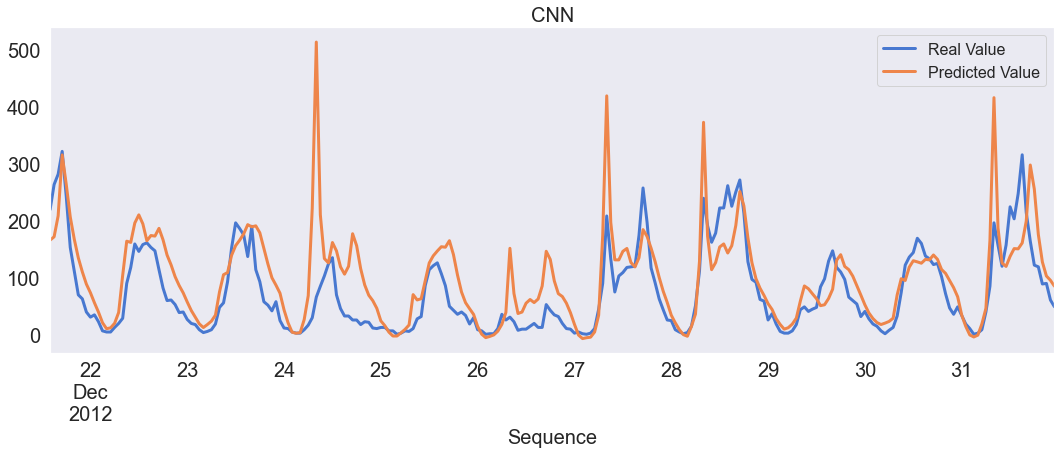

MAE      MSE  MAPE
Score 39.51 3,557.24  1.16

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

Stationarity_adf  Stationarity_kpss  Normality  \
Test Statistics                          -8.32               0.49       0.85   
p-value                                   0.00               0.04       0.00   
Used Lag                                  1.00              16.00        NaN   
Used Observations                       248.00                NaN        NaN   
Critical Value(1%)                       -3.46                NaN        NaN   
Maximum Information Criteria          2,406.30                NaN        NaN   
Critical Value(10%)                        NaN               0.35        NaN   
Alternative                                NaN                NaN        NaN   

                              Autocorr(lag1)  Autocorr(lag5)  Autocorr(lag10)  \
Test Statistics                       103.75          127.91           148.16   
p-value                                 0.00            0.00             0.00   
Used Lag                                 NaN             NaN              NaN   
Used Observations                        NaN             NaN              NaN   
Critical Value(1%)                       NaN             NaN              NaN   
Maximum Information Criteria             NaN             NaN              NaN   
Critical Value(10%)                      NaN             NaN              NaN   
Alternative                              NaN             NaN              NaN   

                              Autocorr(lag50) Heteroscedasticity  
Test Statistics                        341.36               1.30  
p-value                                  0.00               0.17  
Used Lag                                  NaN                NaN  
Used Observations                         NaN                NaN  
Critical Value(1%)                        NaN                NaN  
Maximum Information Criteria              NaN                NaN  
Critical Value(10%)                       NaN                NaN  
Alternative                               NaN          two-sided

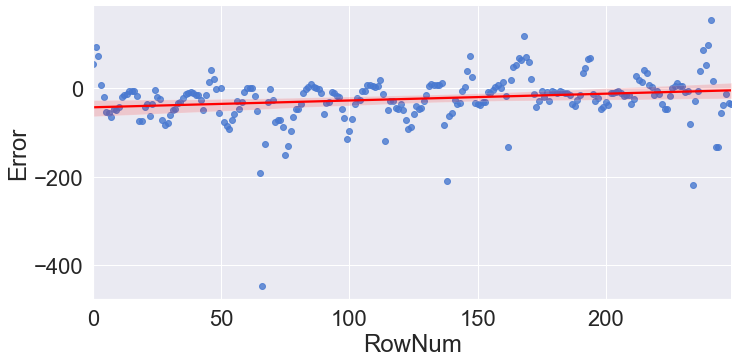

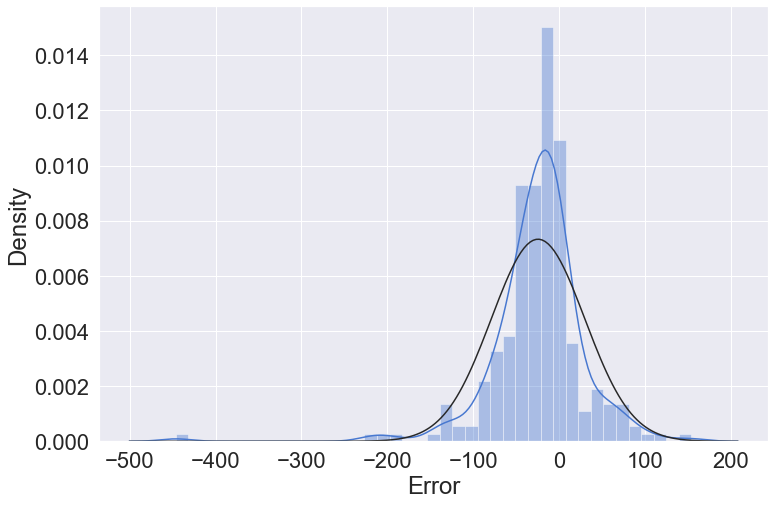

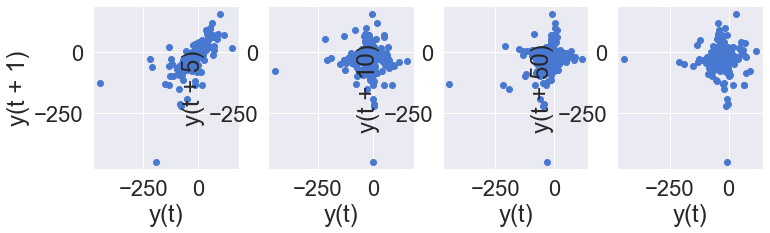

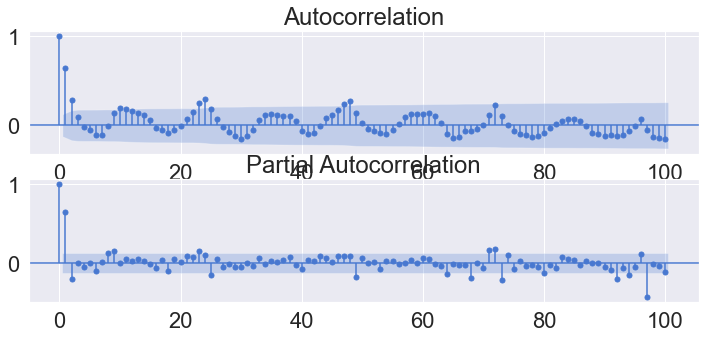

In [9]:
# Loading of Best Learning 
algo_CNN = load_model(RESULT_LOCATION+'CNN.h5')

# Prediction
Y_pred = algo_CNN.predict(X_test)
Y_pred = pd.DataFrame(Y_pred, index=Y_test.index, columns=Y_colname)

# Evaluation
evaluation_reg_PredPlot(Y_test, Y_pred, title='CNN', ylabel='')
Score, Resid_te = evaluation_reg_MAE_MSE_MAPE(Y_test, Y_pred)
display(Score)

# Error Analysis
Resid_te.rename(columns={Y_colname[0]:'Error'}, inplace=True)
X_test_old = pd.DataFrame(X_test_old, index=Y_test.index, 
                      columns=[i for i in df.columns if i not in Y_colname])
ErrorResult = error_analysis(Resid_te, X_test_old, graph_on=True)
display(ErrorResult)

# Summary
Score_CNN = Score.copy()
Y_pred_CNN = Y_pred.copy()
Error_CNN = ErrorResult.copy()

## RNN

X_train: (4500, 24) Y_train: (4500, 1)
X_val: (250, 24) Y_val: (250, 1)
X_test: (250, 24) Y_test: (250, 1)
X_train: (4491, 10, 24) Y_train: (4491, 1)
X_val: (250, 10, 24) Y_val: (250, 1)
X_test: (250, 10, 24) Y_test: (250, 1)
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 10, 24)]          0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 10, 128)           19584     
_________________________________________________________________
dropout_4 (Dropout)          (None, 10, 128)           0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 10, 64)            12352     
_________________________________________________________________
dropout_5 (Dropout)          (None, 10, 64)            0         
_______________________________

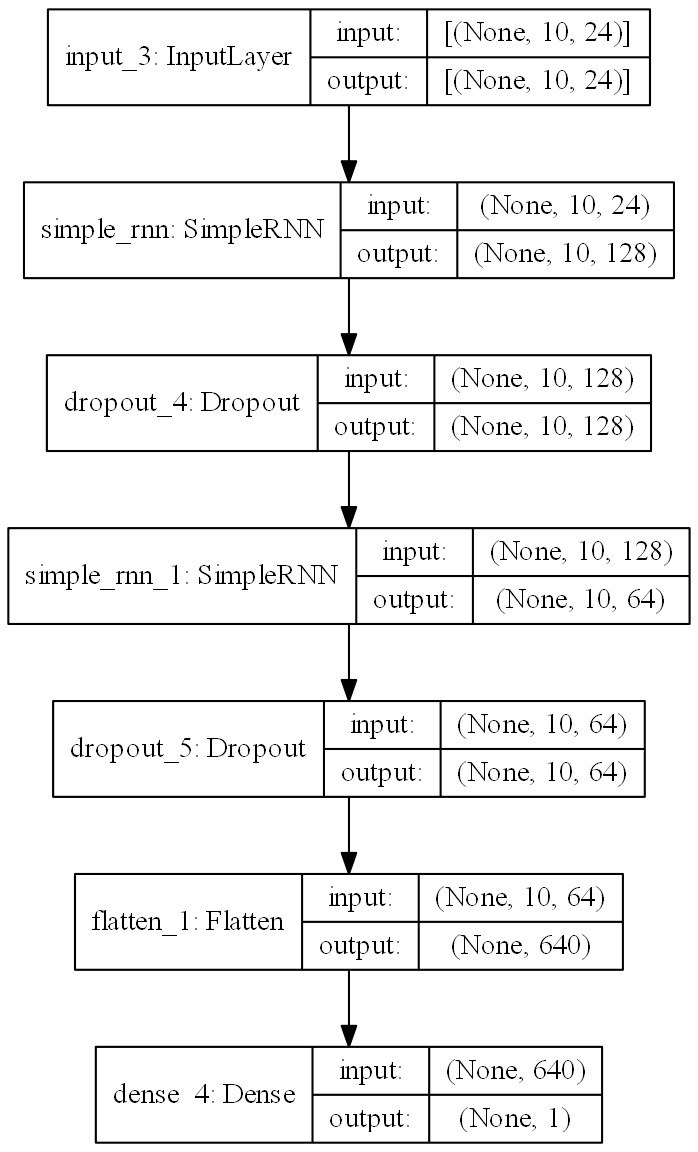

Training:   0%|                                                                                      0/50 ETA:…

Epoch 00037: early stopping


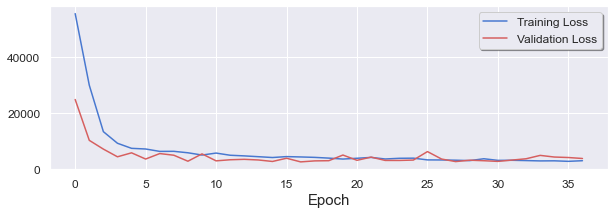

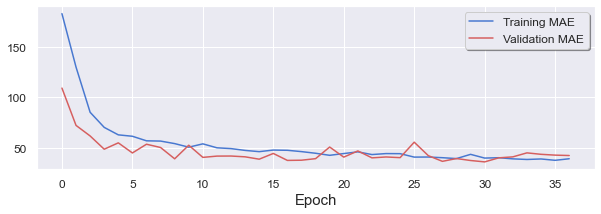

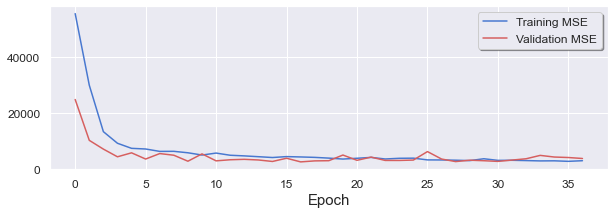

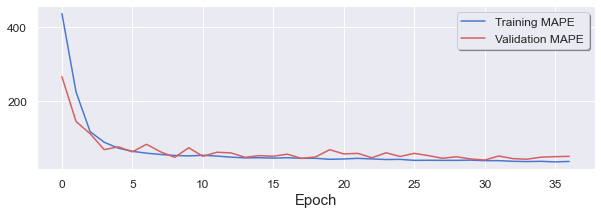

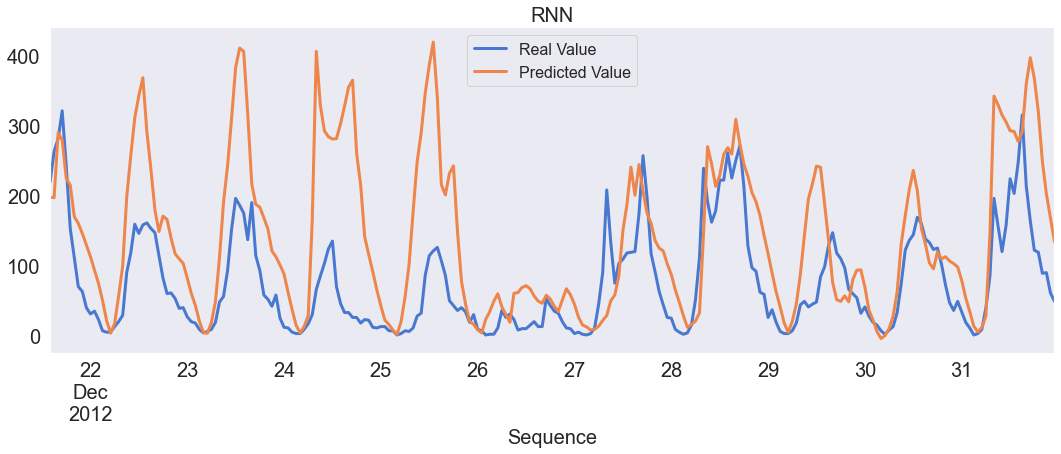

MAE       MSE  MAPE
Score 74.88 10,929.36  2.35

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

Stationarity_adf  Stationarity_kpss  Normality  \
Test Statistics                          -6.14               0.29       0.93   
p-value                                   0.00               0.10       0.00   
Used Lag                                  1.00              16.00        NaN   
Used Observations                       248.00                NaN        NaN   
Critical Value(1%)                       -3.46                NaN        NaN   
Maximum Information Criteria          2,376.86                NaN        NaN   
Critical Value(10%)                        NaN               0.35        NaN   
Alternative                                NaN                NaN        NaN   

                              Autocorr(lag1)  Autocorr(lag5)  Autocorr(lag10)  \
Test Statistics                       186.33          373.85           383.48   
p-value                                 0.00            0.00             0.00   
Used Lag                                 NaN             NaN              NaN   
Used Observations                        NaN             NaN              NaN   
Critical Value(1%)                       NaN             NaN              NaN   
Maximum Information Criteria             NaN             NaN              NaN   
Critical Value(10%)                      NaN             NaN              NaN   
Alternative                              NaN             NaN              NaN   

                              Autocorr(lag50) Heteroscedasticity  
Test Statistics                        692.26               0.62  
p-value                                  0.00               0.01  
Used Lag                                  NaN                NaN  
Used Observations                         NaN                NaN  
Critical Value(1%)                        NaN                NaN  
Maximum Information Criteria              NaN                NaN  
Critical Value(10%)                       NaN                NaN  
Alternative                               NaN          two-sided

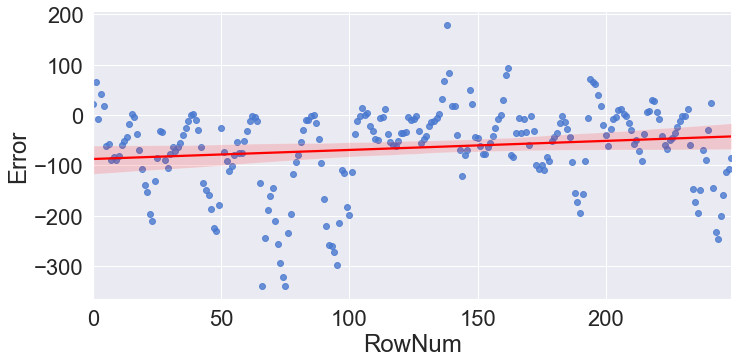

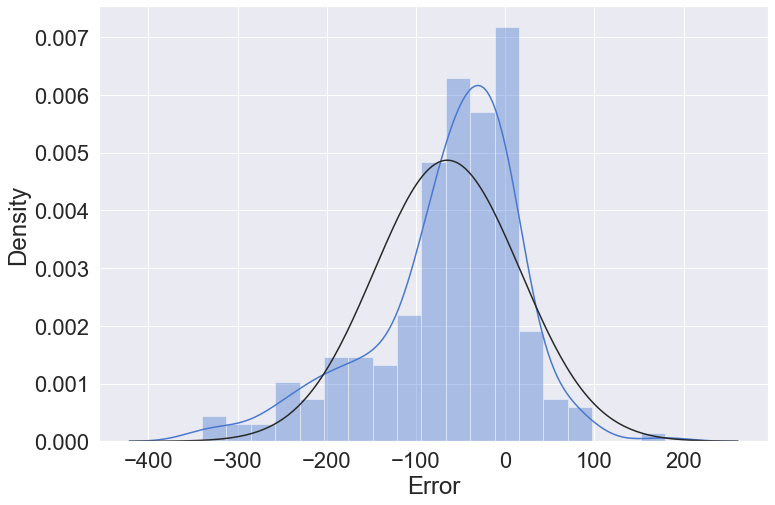

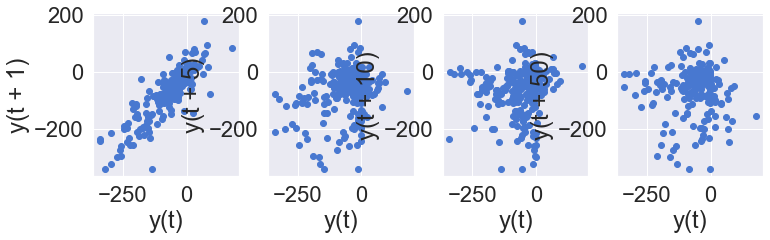

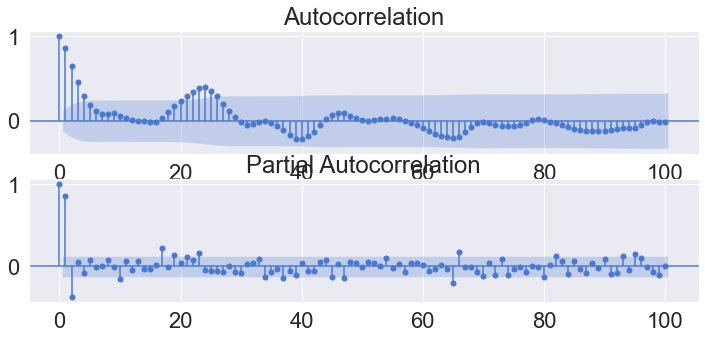

In [10]:
# Data Loading
location = os.path.join(os.getcwd(),'Data','BikeSharingDemand','Bike_Sharing_Demand_Full.csv')
df = pd.read_csv(location)

# Preprocessing
X_colname = [x for x in df.columns if x not in Y_colname+X_remove]
df = feature_engineering(df)

X_colname = [x for x in df.columns if x not in Y_colname+X_remove]
target = ['count_trend', 'count_seasonal', 'count_Day', 'count_Week', 'count_diff']
df = feature_engineering_year_duplicated(df, target)
df = df[Y_colname + X_colname].copy()
df = df[-5000:].copy()

X_train, X_test, \
Y_train, Y_test = datasplit_timeseries_ratio(df, Y_colname, 
                                             test_ratio=TEST_RATIO, shape_show=False)
X_val, X_test, \
Y_val, Y_test = datasplit_timeseries_ratio(pd.concat([X_test, Y_test], axis=1), Y_colname, 
                                           test_ratio=0.5, shape_show=False)
target = ['count_lag1', 'count_lag2']
X_train = feature_engineering_lag_modified(Y_train, X_train, target)
X_val = feature_engineering_lag_modified(Y_val, X_val, target)
X_test = feature_engineering_lag_modified(Y_test, X_test, target)

# Scaling
scaler_fit = scaler.fit(X_train)
X_train = scaler_fit.transform(X_train)
X_val = scaler_fit.transform(X_val)
X_test = scaler_fit.transform(X_test)
print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
print('X_val:', X_val.shape, 'Y_val:', Y_val.shape)
print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

# Reshape
X_test_old = X_test.copy()
X, Y = reshape_2Dto3Dseq(np.concatenate((X_train, X_val, X_test), axis=0),
                         pd.concat([Y_train, Y_val, Y_test], axis=0), SEQUENCE)
test_length = Y_test.shape[0]
X_train, Y_train = X[:-test_length*2,:,:], Y.iloc[:-test_length*2,:]
X_val, Y_val = X[-test_length*2:-test_length,:,:], Y.iloc[-test_length*2:-test_length,:]
X_test, Y_test = X[-test_length:,:,:], Y.iloc[-test_length:,:]
print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
print('X_val:', X_val.shape, 'Y_val:', Y_val.shape)
print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

# RNN
inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
hiddens = SimpleRNN(128, return_sequences=True, activation='relu')(inputs)
hiddens = Dropout(DROPOUT_RATIO)(hiddens)
# hiddens = SimpleRNN(256, return_sequences=True, activation='relu')(hiddens)
# hiddens = Dropout(DROPOUT_RATIO)(hiddens)
# hiddens = SimpleRNN(128, return_sequences=True, activation='relu')(hiddens)
# hiddens = Dropout(DROPOUT_RATIO)(hiddens)
hiddens = SimpleRNN(64, return_sequences=True, activation='relu')(hiddens)
hiddens = Dropout(DROPOUT_RATIO)(hiddens)
hiddens = Flatten()(hiddens)
outputs = Dense(1)(hiddens)
algo_RNN = Model(inputs, outputs)
algo_RNN.summary()
display(plot_model(algo_RNN, to_file=RESULT_LOCATION+'RNN.png', 
                   show_shapes=True, dpi=RESULT_DPI))

# Learning
CALLBACK = [tfa.callbacks.TQDMProgressBar(show_epoch_progress=False),
            callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                    patience=EARLYSTOP_PATIENT, verbose=1),
            callbacks.ModelCheckpoint(monitor='val_loss', mode='min', save_best_only=True, 
                                      filepath=RESULT_LOCATION+'RNN.h5')]

algo_RNN.compile(loss='mse', optimizer='adam',
                 metrics=['mae', 'mse', 'mape'])
algo_RNNfit = algo_RNN.fit(X_train, Y_train, 
                           batch_size=BATCH_SIZE, epochs=EPOCHS,
                           validation_data=(X_val, Y_val),
                           verbose=VERBOSE,
                           callbacks=[CALLBACK])
evaluation_reg_LearningPlot(algo_RNNfit)

# Prediction
Y_pred = algo_RNN.predict(X_test)
Y_pred = pd.DataFrame(Y_pred, index=Y_test.index, columns=Y_colname)

# Evaluation
evaluation_reg_PredPlot(Y_test, Y_pred, title='RNN', ylabel='')
Score, Resid_te = evaluation_reg_MAE_MSE_MAPE(Y_test, Y_pred)
display(Score)

# Error Analysis
Resid_te.rename(columns={Y_colname[0]:'Error'}, inplace=True)
X_test_old = pd.DataFrame(X_test_old, index=Y_test.index, 
                      columns=[i for i in df.columns if i not in Y_colname])
ErrorResult = error_analysis(Resid_te, X_test_old, graph_on=True)
display(ErrorResult)

# Summary
Score_RNN = Score.copy()
Y_pred_RNN = Y_pred.copy()
Error_RNN = ErrorResult.copy()

### Load Best Learning

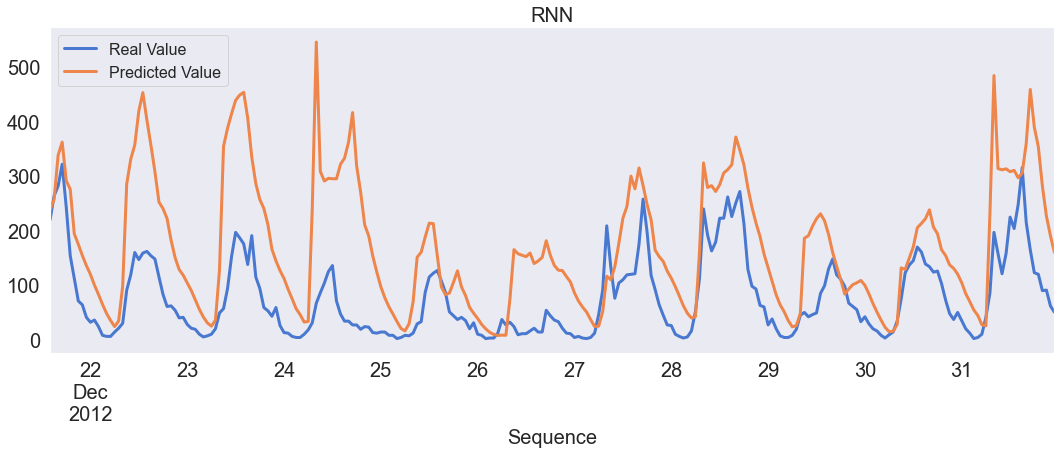

MAE       MSE  MAPE
Score 98.56 16,008.18  4.06

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

Stationarity_adf  Stationarity_kpss  Normality  \
Test Statistics                          -4.22               0.30       0.92   
p-value                                   0.00               0.10       0.00   
Used Lag                                  9.00              16.00        NaN   
Used Observations                       240.00                NaN        NaN   
Critical Value(1%)                       -3.46                NaN        NaN   
Maximum Information Criteria          2,454.86                NaN        NaN   
Critical Value(10%)                        NaN               0.35        NaN   
Alternative                                NaN                NaN        NaN   

                              Autocorr(lag1)  Autocorr(lag5)  Autocorr(lag10)  \
Test Statistics                       170.03          350.25           364.29   
p-value                                 0.00            0.00             0.00   
Used Lag                                 NaN             NaN              NaN   
Used Observations                        NaN             NaN              NaN   
Critical Value(1%)                       NaN             NaN              NaN   
Maximum Information Criteria             NaN             NaN              NaN   
Critical Value(10%)                      NaN             NaN              NaN   
Alternative                              NaN             NaN              NaN   

                              Autocorr(lag50) Heteroscedasticity  
Test Statistics                        618.42               0.46  
p-value                                  0.00               0.00  
Used Lag                                  NaN                NaN  
Used Observations                         NaN                NaN  
Critical Value(1%)                        NaN                NaN  
Maximum Information Criteria              NaN                NaN  
Critical Value(10%)                       NaN                NaN  
Alternative                               NaN          two-sided

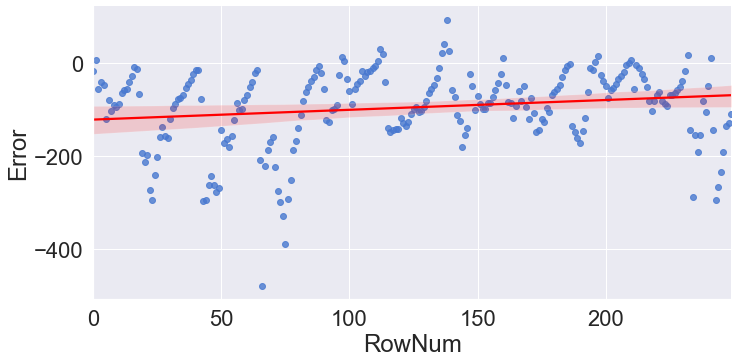

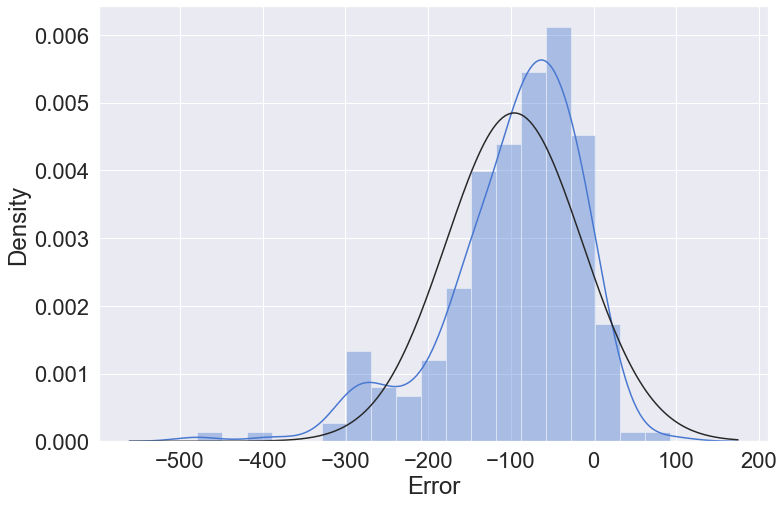

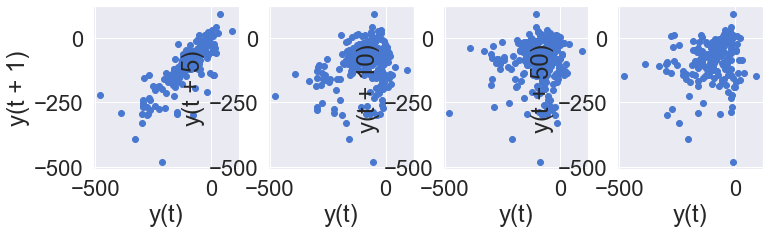

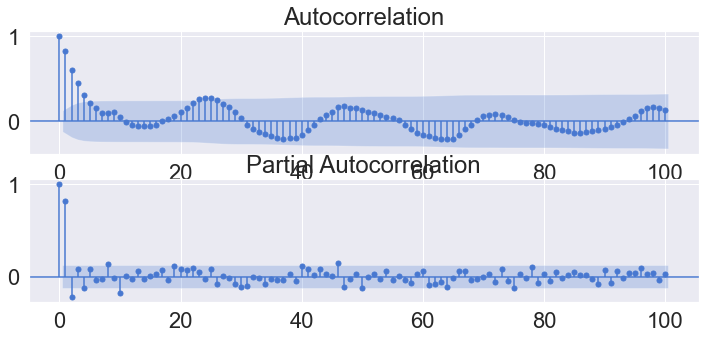

In [11]:
# Loading of Best Learning 
algo_RNN = load_model(RESULT_LOCATION+'RNN.h5')

# Prediction
Y_pred = algo_RNN.predict(X_test)
Y_pred = pd.DataFrame(Y_pred, index=Y_test.index, columns=Y_colname)

# Evaluation
evaluation_reg_PredPlot(Y_test, Y_pred, title='RNN', ylabel='')
Score, Resid_te = evaluation_reg_MAE_MSE_MAPE(Y_test, Y_pred)
display(Score)

# Error Analysis
Resid_te.rename(columns={Y_colname[0]:'Error'}, inplace=True)
X_test_old = pd.DataFrame(X_test_old, index=Y_test.index, 
                      columns=[i for i in df.columns if i not in Y_colname])
ErrorResult = error_analysis(Resid_te, X_test_old, graph_on=True)
display(ErrorResult)

# Summary
Score_RNN = Score.copy()
Y_pred_RNN = Y_pred.copy()
Error_RNN = ErrorResult.copy()

## LSTM

X_train: (4500, 24) Y_train: (4500, 1)
X_val: (250, 24) Y_val: (250, 1)
X_test: (250, 24) Y_test: (250, 1)
X_train: (4491, 10, 24) Y_train: (4491, 1)
X_val: (250, 10, 24) Y_val: (250, 1)
X_test: (250, 10, 24) Y_test: (250, 1)
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 10, 24)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 10, 128)           78336     
_________________________________________________________________
dropout_6 (Dropout)          (None, 10, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_______________________________

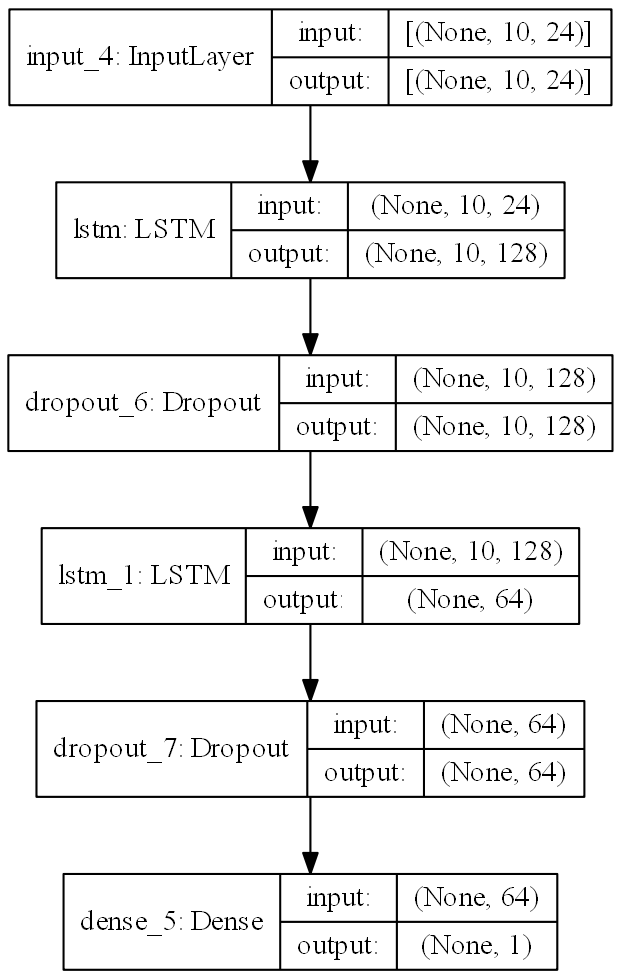

Training:   0%|                                                                                      0/50 ETA:…

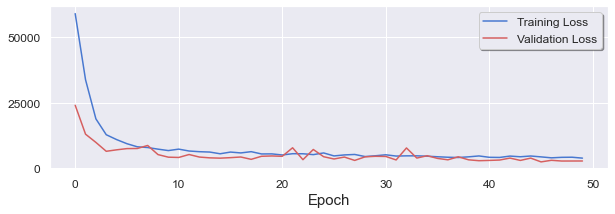

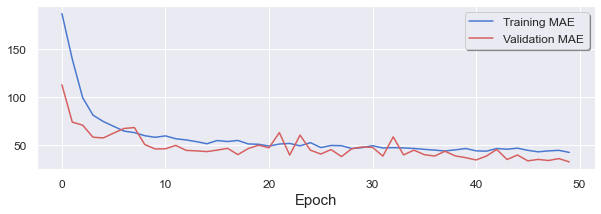

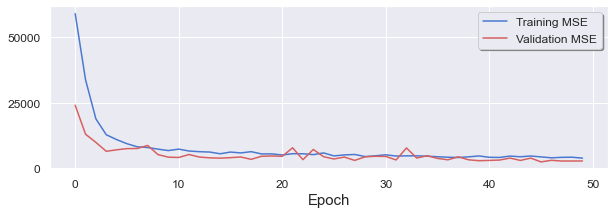

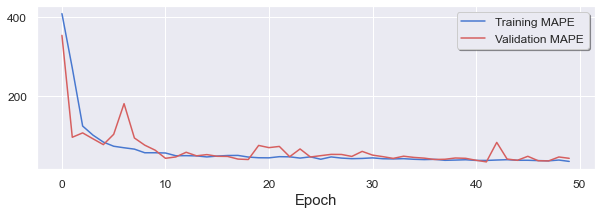

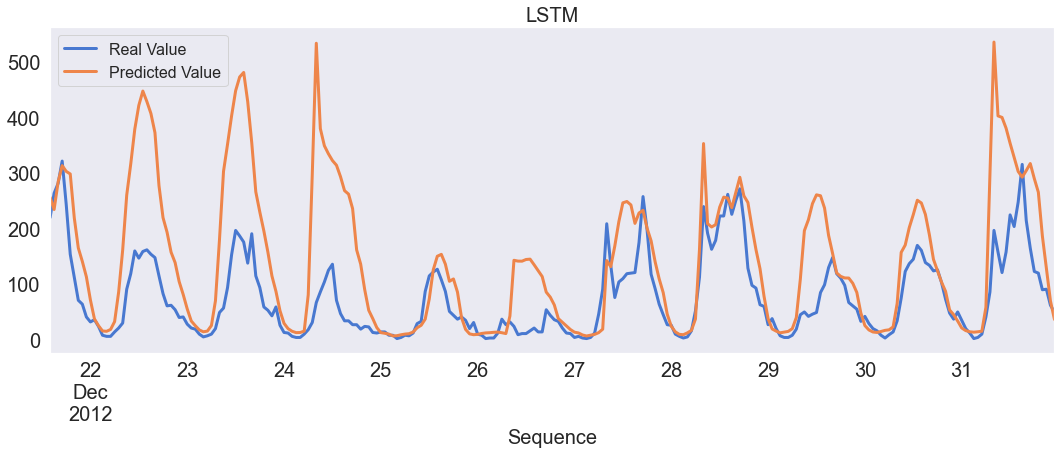

MAE       MSE  MAPE
Score 72.31 12,504.97  1.70

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

Stationarity_adf  Stationarity_kpss  Normality  \
Test Statistics                          -4.93               0.34       0.85   
p-value                                   0.00               0.10       0.00   
Used Lag                                  9.00              16.00        NaN   
Used Observations                       240.00                NaN        NaN   
Critical Value(1%)                       -3.46                NaN        NaN   
Maximum Information Criteria          2,368.88                NaN        NaN   
Critical Value(10%)                        NaN               0.35        NaN   
Alternative                                NaN                NaN        NaN   

                              Autocorr(lag1)  Autocorr(lag5)  Autocorr(lag10)  \
Test Statistics                       197.36          442.74           453.22   
p-value                                 0.00            0.00             0.00   
Used Lag                                 NaN             NaN              NaN   
Used Observations                        NaN             NaN              NaN   
Critical Value(1%)                       NaN             NaN              NaN   
Maximum Information Criteria             NaN             NaN              NaN   
Critical Value(10%)                      NaN             NaN              NaN   
Alternative                              NaN             NaN              NaN   

                              Autocorr(lag50) Heteroscedasticity  
Test Statistics                        928.11               0.53  
p-value                                  0.00               0.00  
Used Lag                                  NaN                NaN  
Used Observations                         NaN                NaN  
Critical Value(1%)                        NaN                NaN  
Maximum Information Criteria              NaN                NaN  
Critical Value(10%)                       NaN                NaN  
Alternative                               NaN          two-sided

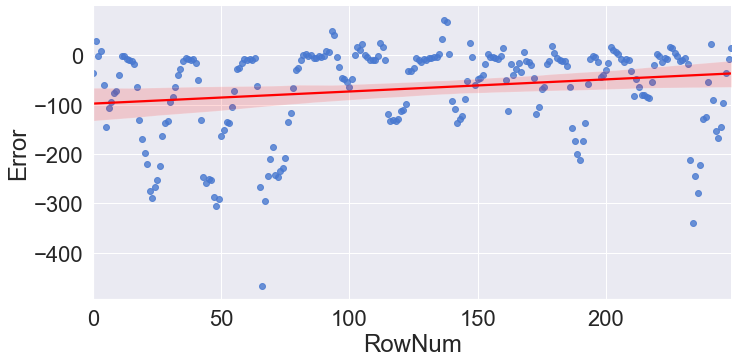

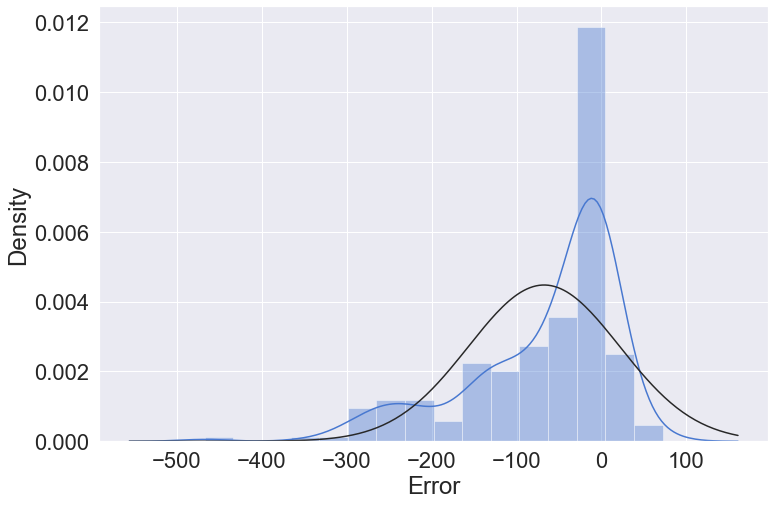

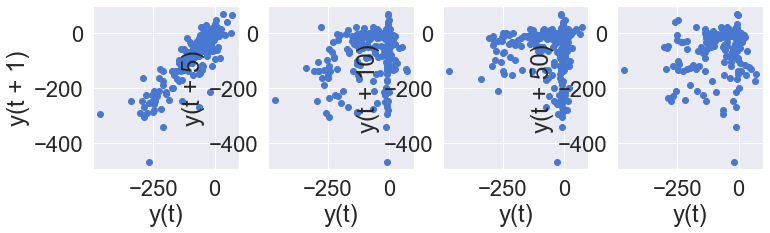

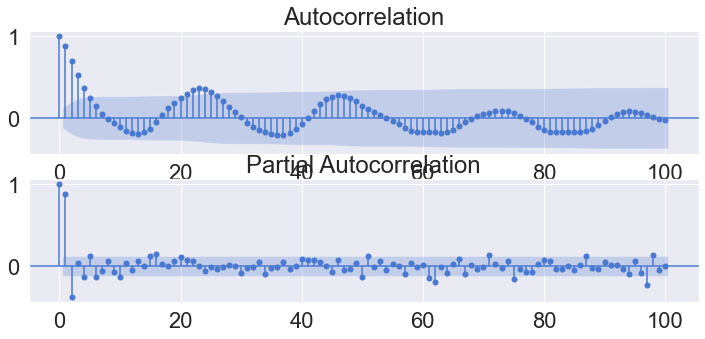

In [12]:
# Data Loading
location = os.path.join(os.getcwd(),'Data','BikeSharingDemand','Bike_Sharing_Demand_Full.csv')
df = pd.read_csv(location)

# Preprocessing
X_colname = [x for x in df.columns if x not in Y_colname+X_remove]
df = feature_engineering(df)

X_colname = [x for x in df.columns if x not in Y_colname+X_remove]
target = ['count_trend', 'count_seasonal', 'count_Day', 'count_Week', 'count_diff']
df = feature_engineering_year_duplicated(df, target)
df = df[Y_colname + X_colname].copy()
df = df[-5000:].copy()

X_train, X_test, \
Y_train, Y_test = datasplit_timeseries_ratio(df, Y_colname, 
                                             test_ratio=TEST_RATIO, shape_show=False)
X_val, X_test, \
Y_val, Y_test = datasplit_timeseries_ratio(pd.concat([X_test, Y_test], axis=1), Y_colname, 
                                           test_ratio=0.5, shape_show=False)
target = ['count_lag1', 'count_lag2']
X_train = feature_engineering_lag_modified(Y_train, X_train, target)
X_val = feature_engineering_lag_modified(Y_val, X_val, target)
X_test = feature_engineering_lag_modified(Y_test, X_test, target)

# Scaling
scaler_fit = scaler.fit(X_train)
X_train = scaler_fit.transform(X_train)
X_val = scaler_fit.transform(X_val)
X_test = scaler_fit.transform(X_test)
print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
print('X_val:', X_val.shape, 'Y_val:', Y_val.shape)
print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

# Reshape
X_test_old = X_test.copy()
X, Y = reshape_2Dto3Dseq(np.concatenate((X_train, X_val, X_test), axis=0),
                         pd.concat([Y_train, Y_val, Y_test], axis=0), SEQUENCE)
test_length = Y_test.shape[0]
X_train, Y_train = X[:-test_length*2,:,:], Y.iloc[:-test_length*2,:]
X_val, Y_val = X[-test_length*2:-test_length,:,:], Y.iloc[-test_length*2:-test_length,:]
X_test, Y_test = X[-test_length:,:,:], Y.iloc[-test_length:,:]
print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
print('X_val:', X_val.shape, 'Y_val:', Y_val.shape)
print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

# LSTM
inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
hiddens = LSTM(128, return_sequences=True, activation='relu')(inputs)
hiddens = Dropout(DROPOUT_RATIO)(hiddens)
# hiddens = LSTM(256, return_sequences=True, activation='relu')(hiddens)
# hiddens = Dropout(DROPOUT_RATIO)(hiddens)
# hiddens = LSTM(128, return_sequences=True, activation='relu')(hiddens)
# hiddens = Dropout(DROPOUT_RATIO)(hiddens)
hiddens = LSTM(64, return_sequences=False, activation='relu')(hiddens)
hiddens = Dropout(DROPOUT_RATIO)(hiddens)
outputs = Dense(1)(hiddens)
algo_LSTM = Model(inputs, outputs)
algo_LSTM.summary()
display(plot_model(algo_LSTM, to_file=RESULT_LOCATION+'LSTM.png', 
                   show_shapes=True, dpi=RESULT_DPI))

# Learning
CALLBACK = [tfa.callbacks.TQDMProgressBar(show_epoch_progress=False),
            callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                    patience=EARLYSTOP_PATIENT, verbose=1),
            callbacks.ModelCheckpoint(monitor='val_loss', mode='min', save_best_only=True, 
                                      filepath=RESULT_LOCATION+'LSTM.h5')]

algo_LSTM.compile(loss='mse', optimizer='adam',
                 metrics=['mae', 'mse', 'mape'])
algo_LSTMfit = algo_LSTM.fit(X_train, Y_train, 
                           batch_size=BATCH_SIZE, epochs=EPOCHS,
                           validation_data=(X_val, Y_val),
                           verbose=VERBOSE,
                           callbacks=[CALLBACK])
evaluation_reg_LearningPlot(algo_LSTMfit)

# Prediction
Y_pred = algo_LSTM.predict(X_test)
Y_pred = pd.DataFrame(Y_pred, index=Y_test.index, columns=Y_colname)

# Evaluation
evaluation_reg_PredPlot(Y_test, Y_pred, title='LSTM', ylabel='')
Score, Resid_te = evaluation_reg_MAE_MSE_MAPE(Y_test, Y_pred)
display(Score)

# Error Analysis
Resid_te.rename(columns={Y_colname[0]:'Error'}, inplace=True)
X_test_old = pd.DataFrame(X_test_old, index=Y_test.index, 
                      columns=[i for i in df.columns if i not in Y_colname])
ErrorResult = error_analysis(Resid_te, X_test_old, graph_on=True)
display(ErrorResult)

# Summary
Score_LSTM = Score.copy()
Y_pred_LSTM = Y_pred.copy()
Error_LSTM = ErrorResult.copy()

### Load Best Learning

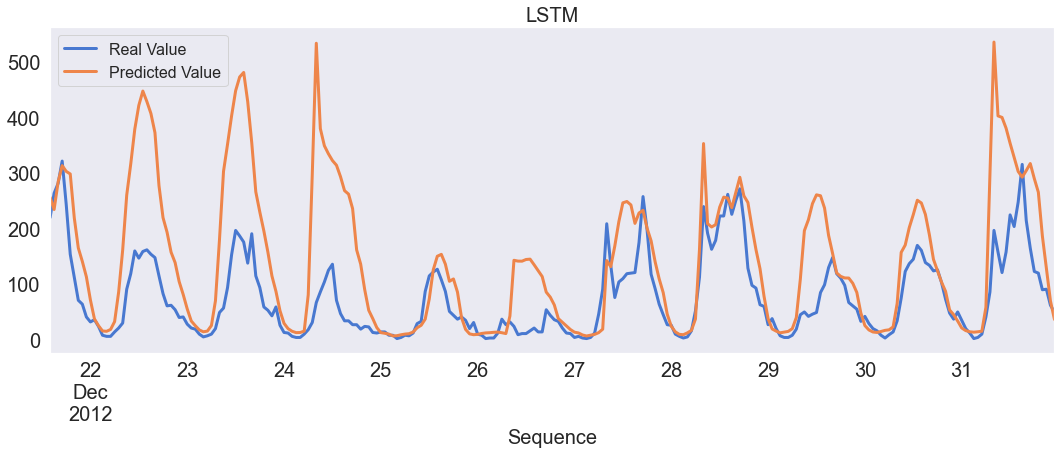

MAE       MSE  MAPE
Score 72.31 12,504.97  1.70

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

Stationarity_adf  Stationarity_kpss  Normality  \
Test Statistics                          -4.93               0.34       0.85   
p-value                                   0.00               0.10       0.00   
Used Lag                                  9.00              16.00        NaN   
Used Observations                       240.00                NaN        NaN   
Critical Value(1%)                       -3.46                NaN        NaN   
Maximum Information Criteria          2,368.88                NaN        NaN   
Critical Value(10%)                        NaN               0.35        NaN   
Alternative                                NaN                NaN        NaN   

                              Autocorr(lag1)  Autocorr(lag5)  Autocorr(lag10)  \
Test Statistics                       197.36          442.74           453.22   
p-value                                 0.00            0.00             0.00   
Used Lag                                 NaN             NaN              NaN   
Used Observations                        NaN             NaN              NaN   
Critical Value(1%)                       NaN             NaN              NaN   
Maximum Information Criteria             NaN             NaN              NaN   
Critical Value(10%)                      NaN             NaN              NaN   
Alternative                              NaN             NaN              NaN   

                              Autocorr(lag50) Heteroscedasticity  
Test Statistics                        928.11               0.53  
p-value                                  0.00               0.00  
Used Lag                                  NaN                NaN  
Used Observations                         NaN                NaN  
Critical Value(1%)                        NaN                NaN  
Maximum Information Criteria              NaN                NaN  
Critical Value(10%)                       NaN                NaN  
Alternative                               NaN          two-sided

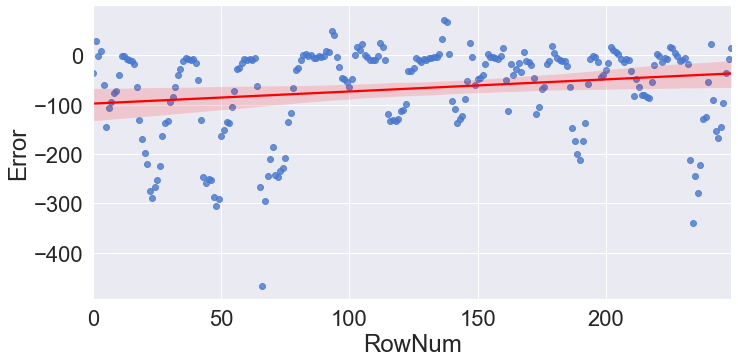

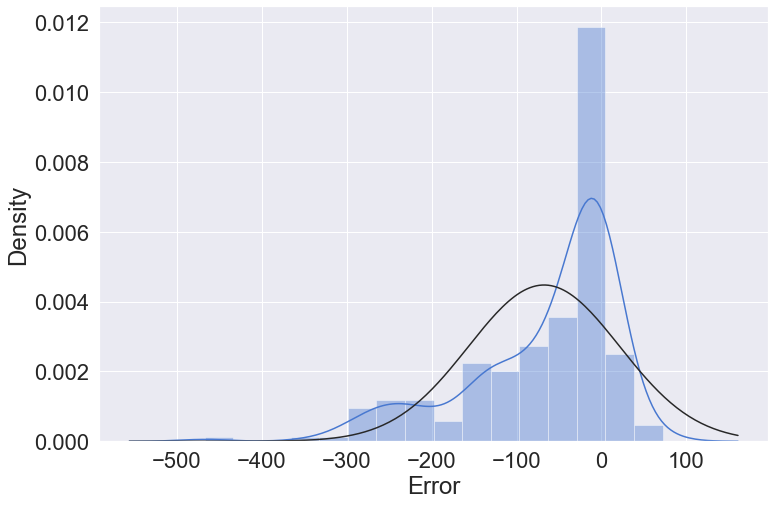

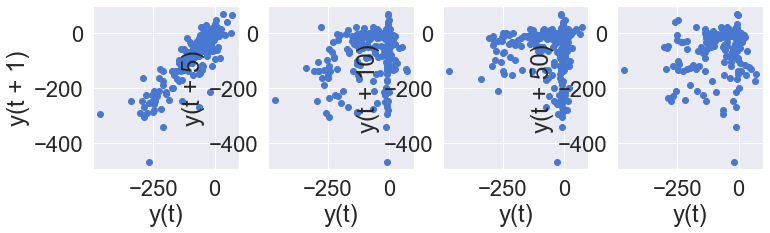

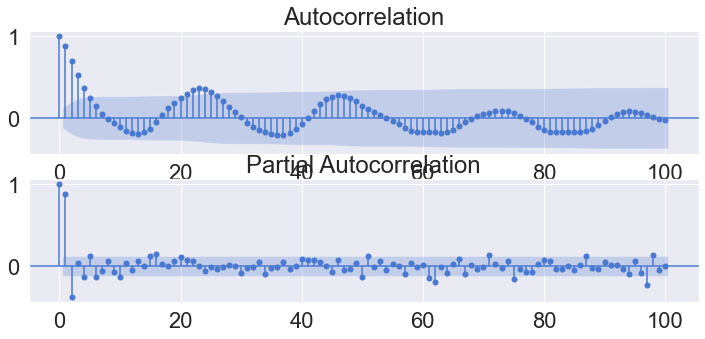

In [13]:
# Loading of Best Learning 
algo_LSTM = load_model(RESULT_LOCATION+'LSTM.h5')

# Evaluation
evaluation_reg_PredPlot(Y_test, Y_pred, title='LSTM', ylabel='')
Score, Resid_te = evaluation_reg_MAE_MSE_MAPE(Y_test, Y_pred)
display(Score)

# Error Analysis
Resid_te.rename(columns={Y_colname[0]:'Error'}, inplace=True)
X_test_old = pd.DataFrame(X_test_old, index=Y_test.index, 
                      columns=[i for i in df.columns if i not in Y_colname])
ErrorResult = error_analysis(Resid_te, X_test_old, graph_on=True)
display(ErrorResult)

# Summary
Score_LSTM = Score.copy()
Y_pred_LSTM = Y_pred.copy()
Error_LSTM = ErrorResult.copy()

## GRU

X_train: (4500, 24) Y_train: (4500, 1)
X_val: (250, 24) Y_val: (250, 1)
X_test: (250, 24) Y_test: (250, 1)
X_train: (4491, 10, 24) Y_train: (4491, 1)
X_val: (250, 10, 24) Y_val: (250, 1)
X_test: (250, 10, 24) Y_test: (250, 1)
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 10, 24)]          0         
_________________________________________________________________
gru (GRU)                    (None, 10, 128)           59136     
_________________________________________________________________
dropout_8 (Dropout)          (None, 10, 128)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                37248     
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)                0         
_______________________________

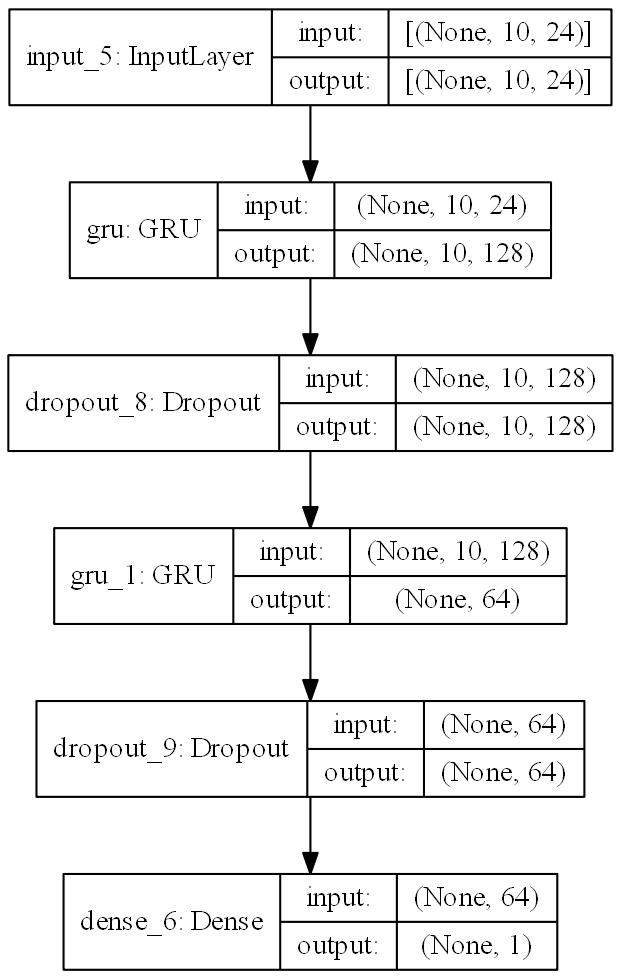

Training:   0%|                                                                                      0/50 ETA:…

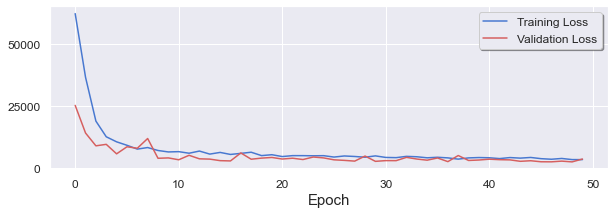

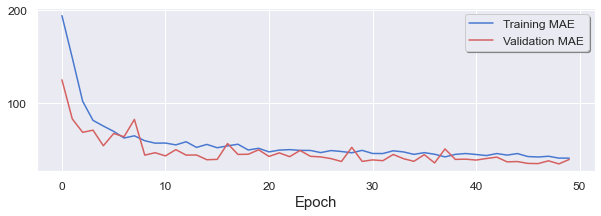

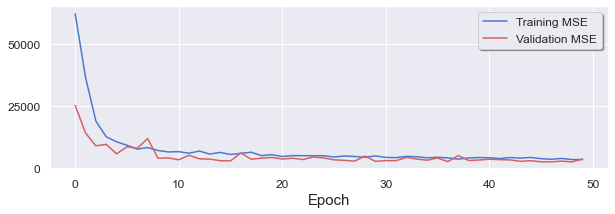

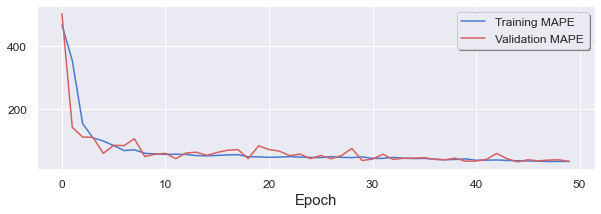

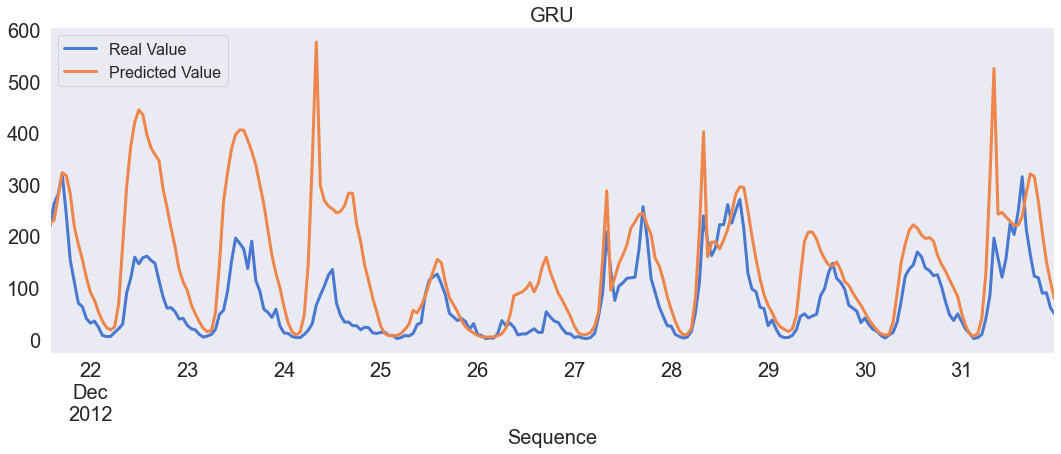

MAE       MSE  MAPE
Score 74.90 11,844.98  1.91

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

Stationarity_adf  Stationarity_kpss  Normality  \
Test Statistics                          -5.40               0.50       0.87   
p-value                                   0.00               0.04       0.00   
Used Lag                                  1.00              16.00        NaN   
Used Observations                       248.00                NaN        NaN   
Critical Value(1%)                       -3.46                NaN        NaN   
Maximum Information Criteria          2,446.37                NaN        NaN   
Critical Value(10%)                        NaN               0.35        NaN   
Alternative                                NaN                NaN        NaN   

                              Autocorr(lag1)  Autocorr(lag5)  Autocorr(lag10)  \
Test Statistics                       176.06          379.46           402.98   
p-value                                 0.00            0.00             0.00   
Used Lag                                 NaN             NaN              NaN   
Used Observations                        NaN             NaN              NaN   
Critical Value(1%)                       NaN             NaN              NaN   
Maximum Information Criteria             NaN             NaN              NaN   
Critical Value(10%)                      NaN             NaN              NaN   
Alternative                              NaN             NaN              NaN   

                              Autocorr(lag50) Heteroscedasticity  
Test Statistics                        680.70               0.55  
p-value                                  0.00               0.00  
Used Lag                                  NaN                NaN  
Used Observations                         NaN                NaN  
Critical Value(1%)                        NaN                NaN  
Maximum Information Criteria              NaN                NaN  
Critical Value(10%)                       NaN                NaN  
Alternative                               NaN          two-sided

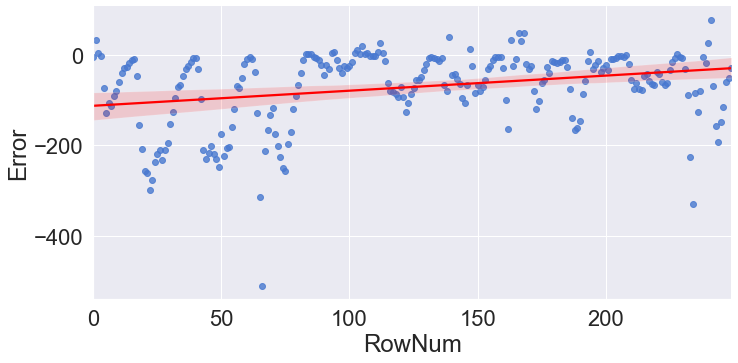

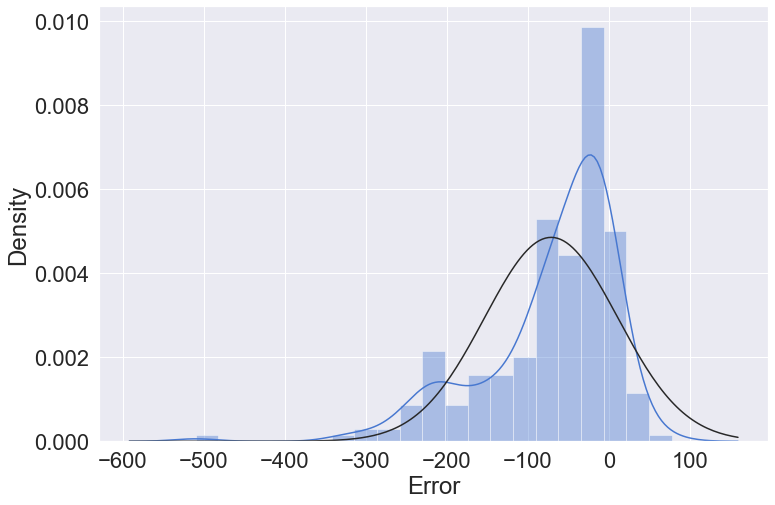

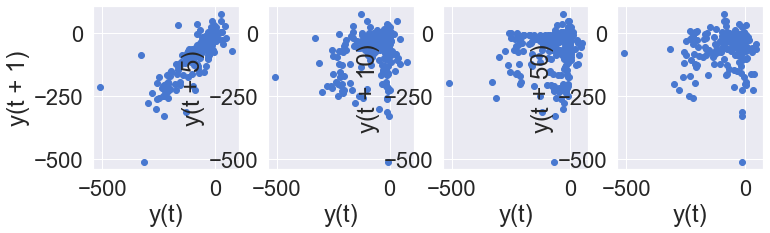

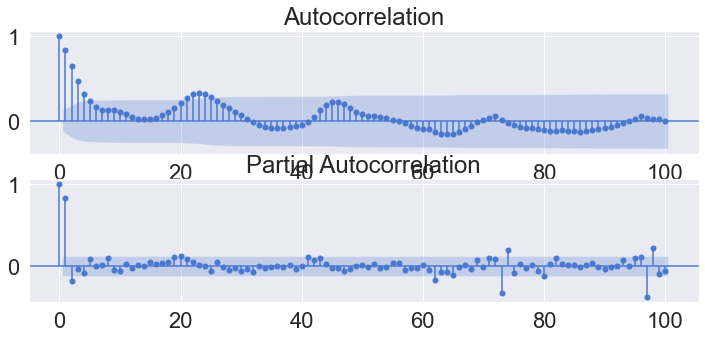

In [14]:
# Data Loading
location = os.path.join(os.getcwd(),'Data','BikeSharingDemand','Bike_Sharing_Demand_Full.csv')
df = pd.read_csv(location)

# Preprocessing
X_colname = [x for x in df.columns if x not in Y_colname+X_remove]
df = feature_engineering(df)

X_colname = [x for x in df.columns if x not in Y_colname+X_remove]
target = ['count_trend', 'count_seasonal', 'count_Day', 'count_Week', 'count_diff']
df = feature_engineering_year_duplicated(df, target)
df = df[Y_colname + X_colname].copy()
df = df[-5000:].copy()

X_train, X_test, \
Y_train, Y_test = datasplit_timeseries_ratio(df, Y_colname, 
                                             test_ratio=TEST_RATIO, shape_show=False)
X_val, X_test, \
Y_val, Y_test = datasplit_timeseries_ratio(pd.concat([X_test, Y_test], axis=1), Y_colname, 
                                           test_ratio=0.5, shape_show=False)
target = ['count_lag1', 'count_lag2']
X_train = feature_engineering_lag_modified(Y_train, X_train, target)
X_val = feature_engineering_lag_modified(Y_val, X_val, target)
X_test = feature_engineering_lag_modified(Y_test, X_test, target)

# Scaling
scaler_fit = scaler.fit(X_train)
X_train = scaler_fit.transform(X_train)
X_val = scaler_fit.transform(X_val)
X_test = scaler_fit.transform(X_test)
print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
print('X_val:', X_val.shape, 'Y_val:', Y_val.shape)
print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

# Reshape
X_test_old = X_test.copy()
X, Y = reshape_2Dto3Dseq(np.concatenate((X_train, X_val, X_test), axis=0),
                         pd.concat([Y_train, Y_val, Y_test], axis=0), SEQUENCE)
test_length = Y_test.shape[0]
X_train, Y_train = X[:-test_length*2,:,:], Y.iloc[:-test_length*2,:]
X_val, Y_val = X[-test_length*2:-test_length,:,:], Y.iloc[-test_length*2:-test_length,:]
X_test, Y_test = X[-test_length:,:,:], Y.iloc[-test_length:,:]
print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
print('X_val:', X_val.shape, 'Y_val:', Y_val.shape)
print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

# GRU
inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
hiddens = GRU(128, return_sequences=True, activation='relu')(inputs)
hiddens = Dropout(DROPOUT_RATIO)(hiddens)
# hiddens = GRU(256, return_sequences=True, activation='relu')(hiddens)
# hiddens = Dropout(DROPOUT_RATIO)(hiddens)
# hiddens = GRU(128, return_sequences=True, activation='relu')(hiddens)
# hiddens = Dropout(DROPOUT_RATIO)(hiddens)
hiddens = GRU(64, return_sequences=False, activation='relu')(hiddens)
hiddens = Dropout(DROPOUT_RATIO)(hiddens)
outputs = Dense(1)(hiddens)
algo_GRU = Model(inputs, outputs)
algo_GRU.summary()
display(plot_model(algo_GRU, to_file=RESULT_LOCATION+'GRU.png', 
                   show_shapes=True, dpi=RESULT_DPI))

# Learning
CALLBACK = [tfa.callbacks.TQDMProgressBar(show_epoch_progress=False),
            callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                    patience=EARLYSTOP_PATIENT, verbose=1),
            callbacks.ModelCheckpoint(monitor='val_loss', mode='min', save_best_only=True, 
                                      filepath=RESULT_LOCATION+'GRU.h5')]

algo_GRU.compile(loss='mse', optimizer='adam',
                 metrics=['mae', 'mse', 'mape'])
algo_GRUfit = algo_GRU.fit(X_train, Y_train, 
                           batch_size=BATCH_SIZE, epochs=EPOCHS,
                           validation_data=(X_val, Y_val),
                           verbose=VERBOSE,
                           callbacks=[CALLBACK])
evaluation_reg_LearningPlot(algo_GRUfit)

# Prediction
Y_pred = algo_GRU.predict(X_test)
Y_pred = pd.DataFrame(Y_pred, index=Y_test.index, columns=Y_colname)

# Evaluation
evaluation_reg_PredPlot(Y_test, Y_pred, title='GRU', ylabel='')
Score, Resid_te = evaluation_reg_MAE_MSE_MAPE(Y_test, Y_pred)
display(Score)

# Error Analysis
Resid_te.rename(columns={Y_colname[0]:'Error'}, inplace=True)
X_test_old = pd.DataFrame(X_test_old, index=Y_test.index, 
                      columns=[i for i in df.columns if i not in Y_colname])
ErrorResult = error_analysis(Resid_te, X_test_old, graph_on=True)
display(ErrorResult)

# Summary
Score_GRU = Score.copy()
Y_pred_GRU = Y_pred.copy()
Error_GRU = ErrorResult.copy()

### Load Best Learning

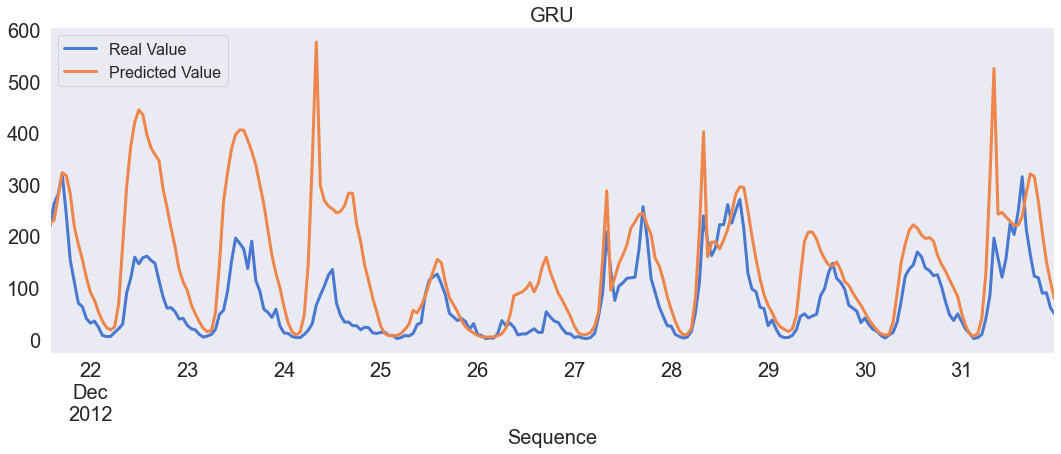

MAE       MSE  MAPE
Score 74.90 11,844.98  1.91

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

Stationarity_adf  Stationarity_kpss  Normality  \
Test Statistics                          -5.40               0.50       0.87   
p-value                                   0.00               0.04       0.00   
Used Lag                                  1.00              16.00        NaN   
Used Observations                       248.00                NaN        NaN   
Critical Value(1%)                       -3.46                NaN        NaN   
Maximum Information Criteria          2,446.37                NaN        NaN   
Critical Value(10%)                        NaN               0.35        NaN   
Alternative                                NaN                NaN        NaN   

                              Autocorr(lag1)  Autocorr(lag5)  Autocorr(lag10)  \
Test Statistics                       176.06          379.46           402.98   
p-value                                 0.00            0.00             0.00   
Used Lag                                 NaN             NaN              NaN   
Used Observations                        NaN             NaN              NaN   
Critical Value(1%)                       NaN             NaN              NaN   
Maximum Information Criteria             NaN             NaN              NaN   
Critical Value(10%)                      NaN             NaN              NaN   
Alternative                              NaN             NaN              NaN   

                              Autocorr(lag50) Heteroscedasticity  
Test Statistics                        680.70               0.55  
p-value                                  0.00               0.00  
Used Lag                                  NaN                NaN  
Used Observations                         NaN                NaN  
Critical Value(1%)                        NaN                NaN  
Maximum Information Criteria              NaN                NaN  
Critical Value(10%)                       NaN                NaN  
Alternative                               NaN          two-sided

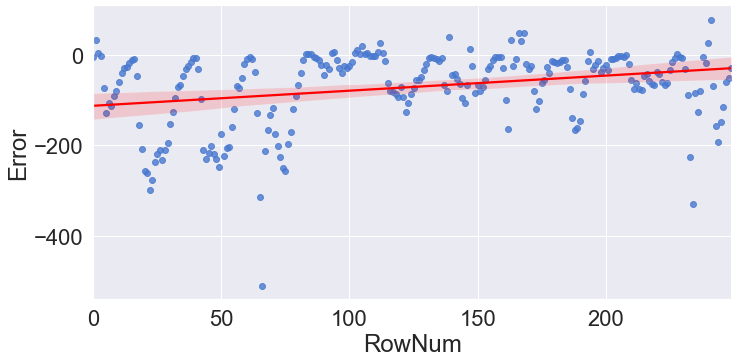

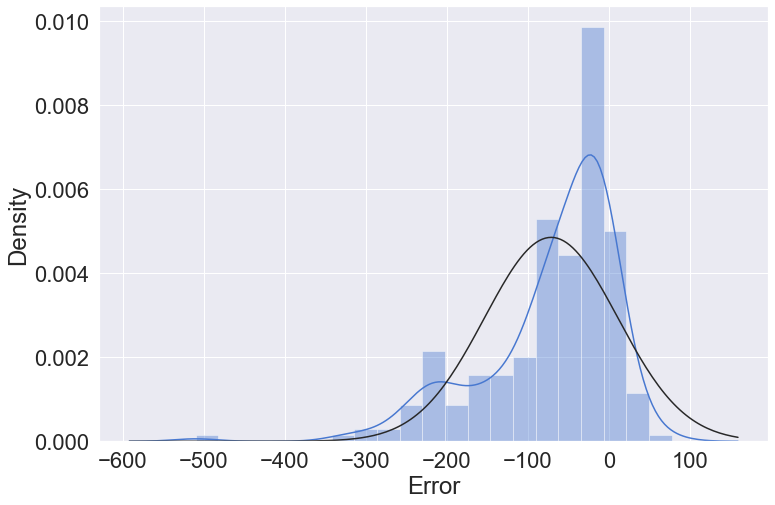

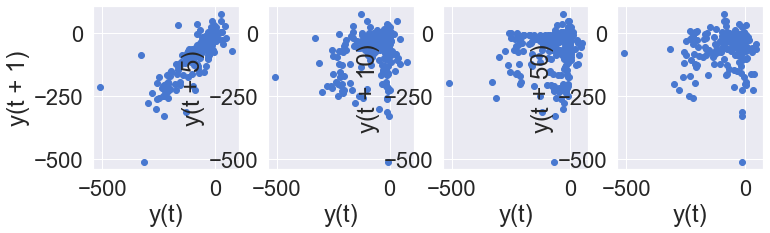

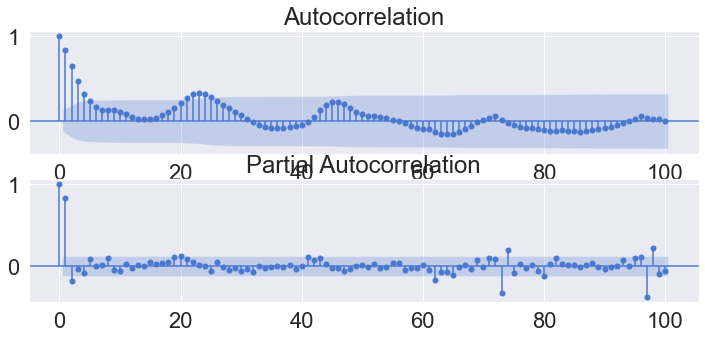

In [15]:
# Loading of Best Learning 
algo_GRU = load_model(RESULT_LOCATION+'GRU.h5')

# Evaluation
evaluation_reg_PredPlot(Y_test, Y_pred, title='GRU', ylabel='')
Score, Resid_te = evaluation_reg_MAE_MSE_MAPE(Y_test, Y_pred)
display(Score)

# Error Analysis
Resid_te.rename(columns={Y_colname[0]:'Error'}, inplace=True)
X_test_old = pd.DataFrame(X_test_old, index=Y_test.index, 
                      columns=[i for i in df.columns if i not in Y_colname])
ErrorResult = error_analysis(Resid_te, X_test_old, graph_on=True)
display(ErrorResult)

# Summary
Score_GRU = Score.copy()
Y_pred_GRU = Y_pred.copy()
Error_GRU = ErrorResult.copy()

# Result Summary

In [16]:
Score_Final = pd.concat([Score_MLP, Score_CNN, Score_RNN, Score_LSTM, Score_GRU], axis=0)
Score_Final.index = ALGO_NAMES
Score_Final

MAE       MSE  MAPE
MLP  62.85 10,780.04  1.70
CNN  39.51  3,557.24  1.16
RNN  98.56 16,008.18  4.06
LSTM 72.31 12,504.97  1.70
GRU  74.90 11,844.98  1.91

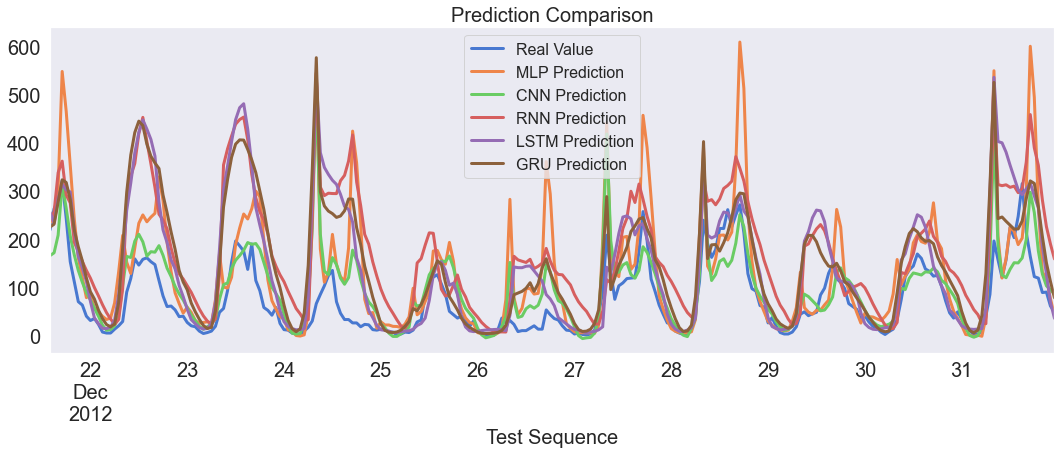

In [17]:
Y_pred_Final = pd.concat([Y_test, Y_pred_MLP, Y_pred_CNN, Y_pred_RNN, Y_pred_LSTM, Y_pred_GRU], axis=1)
Y_pred_Final.columns = ['Real Value']+[i+' Prediction' for i in ALGO_NAMES]
Y_pred_Final.plot(kind='line', figsize=(18,6), linewidth=3, fontsize=20,
                  xlim=(Y_pred_Final.index.min(),Y_pred_Final.index.max()))
plt.title('Prediction Comparison', fontsize=20)
plt.xlabel('Test Sequence', fontsize=20)
plt.ylabel('', fontsize=20)
plt.legend(fontsize=16)
plt.grid()
plt.show()

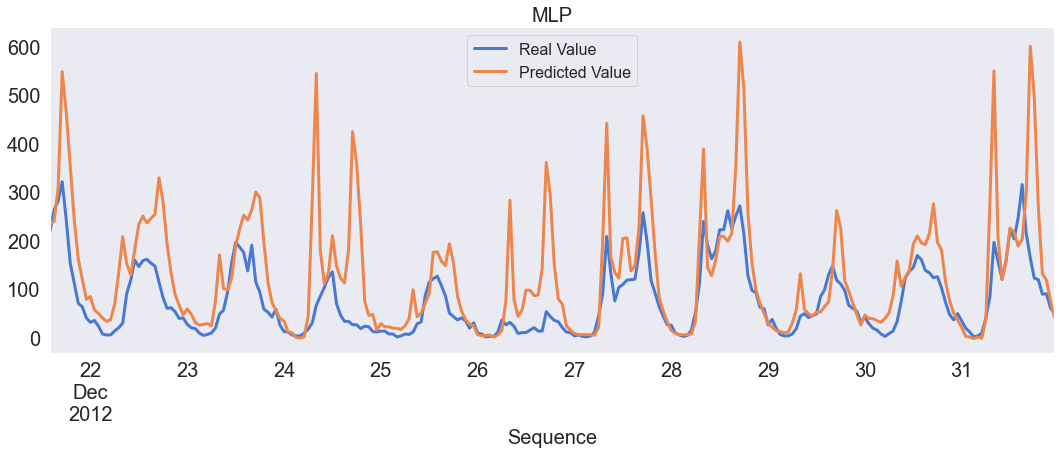

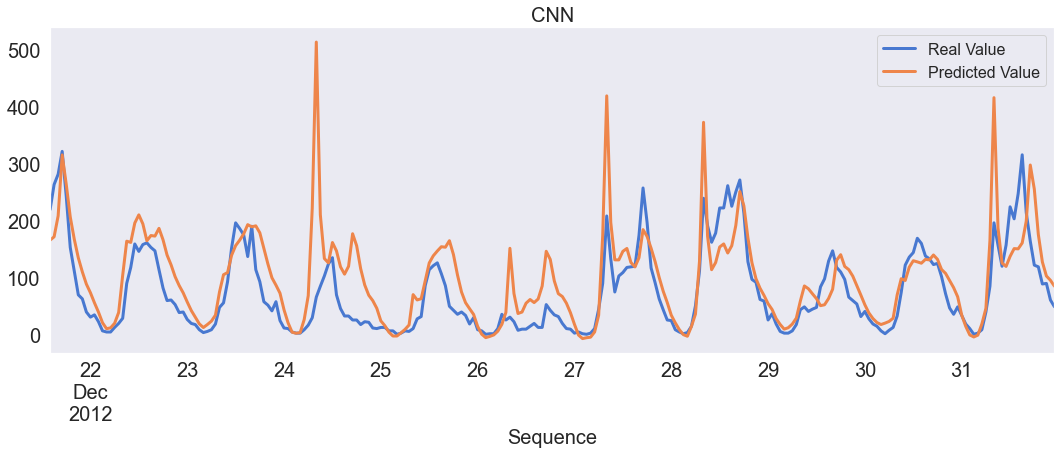

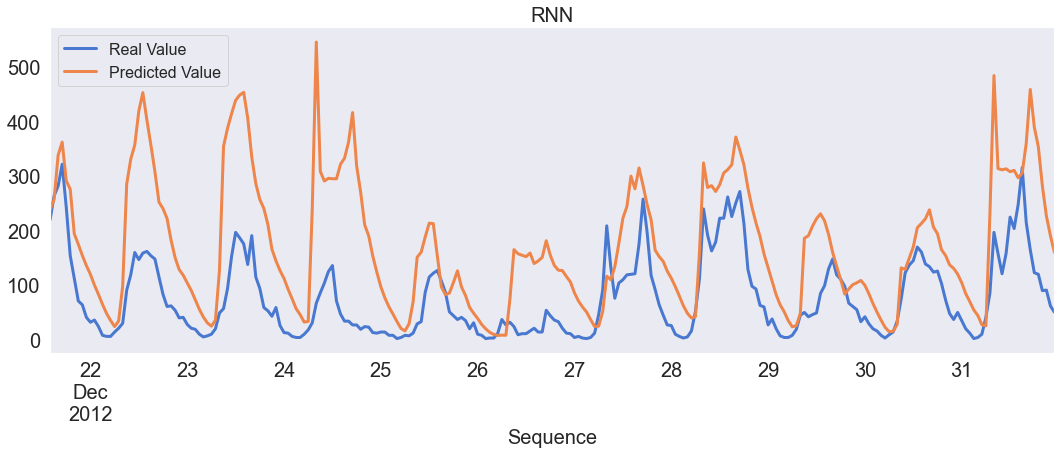

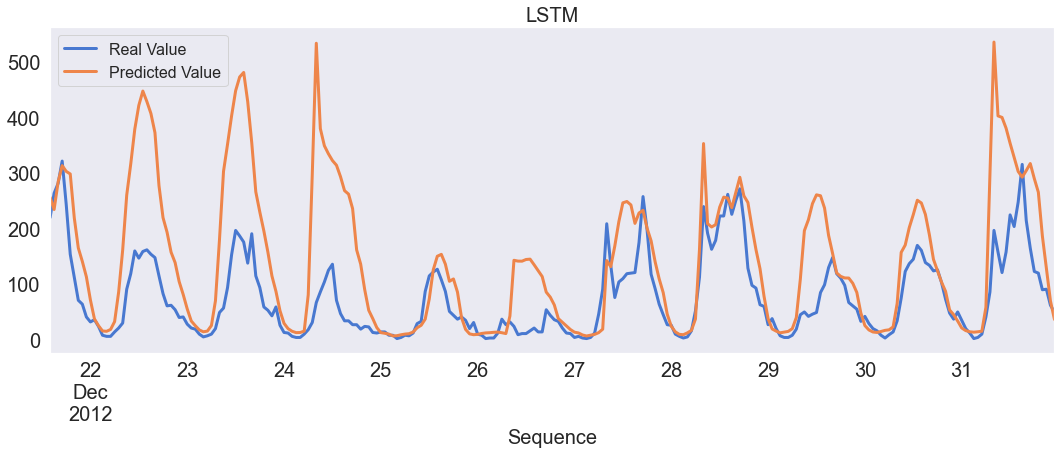

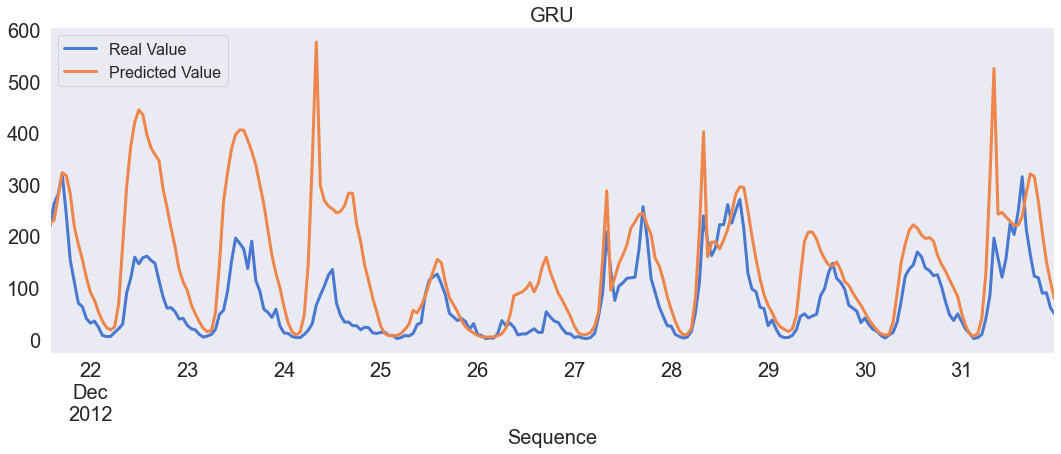

In [18]:
evaluation_reg_PredPlot(Y_test, Y_pred_MLP, title=ALGO_NAMES[0], ylabel='')
evaluation_reg_PredPlot(Y_test, Y_pred_CNN, title=ALGO_NAMES[1], ylabel='')
evaluation_reg_PredPlot(Y_test, Y_pred_RNN, title=ALGO_NAMES[2], ylabel='')
evaluation_reg_PredPlot(Y_test, Y_pred_LSTM, title=ALGO_NAMES[3], ylabel='')
evaluation_reg_PredPlot(Y_test, Y_pred_GRU, title=ALGO_NAMES[4], ylabel='')